# 🏁 Install requirements

In [1]:
from google.colab import drive, userdata
notebook_folder = userdata.get('gdrive_seo_folder')

drive.mount('/content/drive',
            force_remount=True
            )

Mounted at /content/drive


In [2]:
folder_path = "/content/drive/MyDrive/" + notebook_folder  # Beispiel für den Ordnernamen

# Dynamisch den vollständigen Dateipfad erstellen
requirements_file = f"{folder_path}/requirements.txt"

In [3]:
!pip install -r '{requirements_file}'
!python -m spacy download de_core_news_sm
!playwright install
!apt-get update
!apt-get install -y pandoc
# !pip install --upgrade pydantic langchain

  Cloning https://github.com/sethblack/python-seo-analyzer.git to /tmp/pip-req-build-30gspyeh
  Running command git clone --filter=blob:none --quiet https://github.com/sethblack/python-seo-analyzer.git /tmp/pip-req-build-30gspyeh
  Resolved https://github.com/sethblack/python-seo-analyzer.git to commit cfb38f5b39803ec1dc597158c9226ecd9bc07511
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
2025-02-15 11:40:39.404057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739619639.428958    2636 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739619639.436206    2636 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin c

# 🖼frameworks

In [4]:
import os
import requests
from bs4 import BeautifulSoup, Comment
from urllib.parse import urljoin, urlparse
import chardet

import dotenv
# from pyseoanalyzer import analyze

import pandas as pd
import matplotlib.pyplot as plt

import openai
import time

import re
import json

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import ast

import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import string

import seaborn as sns

from wordcloud import WordCloud

from jinja2 import Template

import asyncio
from playwright.async_api import async_playwright
import spacy
import pypandoc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# ⛩ push to github

In [5]:
#%%capture
notebookname = 'SEO.ipynb'

class github:
    def __init__(self, github_pat, github_email, github_username, github_repo, gdrive_notebook_folder, notebook_name):
        self.github_pat = userdata.get(github_pat)
        self.github_email = userdata.get(github_email)
        self.github_username = userdata.get(github_username)
        self.github_repo = userdata.get(github_repo)
        self.gdrive_notebook_folder = userdata.get(gdrive_notebook_folder)
        self.notebook_name = notebook_name

    def clone_repo(self):
        # Source file path in Google Drive
        source_file_path = f"/content/drive/MyDrive/{self.gdrive_notebook_folder}/{self.notebook_name}"

        # Repository details
        repo_url = f'https://{self.github_pat}@github.com/{self.github_username}/{self.github_repo}.git'

        # Clone the private repository
        !git clone {repo_url} cloned-repo
        os.chdir('cloned-repo')  # Switch to the cloned repository

        # Ensure the file exists in Google Drive
        if os.path.exists(source_file_path):
            # Copy the notebook into the cloned repository
            !cp "{source_file_path}" ./
        else:
            print(f"The file {source_file_path} was not found.")
            return  # Exit if the file doesn't exist

        # Git configuration
        !git config user.email "{self.github_email}"
        !git config user.name "{self.github_username}"

        # Add the file to Git
        !git add "{self.notebook_name}"

        # Commit the changes
        !git commit -m "Added {self.notebook_name} from Google Drive"

        # Push to the repository
        !git push origin main

        # Wechsle zurück ins übergeordnete Verzeichnis und lösche cloned-repo
        os.chdir('..')
        !rm -rf cloned-repo
        print("cloned-repo wurde wieder gelöscht.")



# Clone, add, and push the notebook
clone_2 = github('github_pat', 'github_email', 'github_username', 'github_repo_seo', 'gdrive_seo_folder', notebookname)
clone_2.clone_repo()


Cloning into 'cloned-repo'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 295 (delta 47), reused 133 (delta 38), pack-reused 153 (from 1)
Receiving objects: 100% (295/295), 2.88 MiB | 5.07 MiB/s, done.
Resolving deltas: 100% (91/91), done.
[main 36b7d92] Added SEO.ipynb from Google Drive
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite SEO.ipynb (95%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 641 bytes | 641.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/MarkH0705/SEO_Analyses.git
   0533fcb..36b7d92  main -> main
cloned-repo wurde wieder gelöscht.


# 🕸 scrap

In [6]:
class WebsiteScraper:
    """
    Diese Klasse kümmert sich ausschließlich um das Sammeln und Extrahieren
    von Texten aus einer Website.
    """

    def __init__(self, start_url="https://www.rue-zahnspange.de", max_pages=50):
        """
        :param start_url: Die Start-URL der Website, z.B. "https://www.example.com"
        :param max_pages: Maximale Anzahl Seiten, die gecrawlt werden.
        """
        self.start_url = start_url
        self.max_pages = max_pages

        # Hier speichern wir {URL: reiner_Text}
        self.scraped_data = {}

    def scrape_website(self):
        """
        Startet den Crawl-Vorgang, gefolgt von der Extraktion des Textes
        und dem Sammeln interner Links.
        """
        visited = set()
        to_visit = [self.start_url]
        domain = urlparse(self.start_url).netloc

        while to_visit and len(visited) < self.max_pages:
            url = to_visit.pop(0)
            if url in visited:
                continue
            visited.add(url)

            try:
                response = requests.get(url, timeout=10)

                # Rohdaten holen und Encoding per chardet bestimmen
                raw_data = response.content
                detected = chardet.detect(raw_data)
                # Wenn chardet etwas erkennt, nehmen wir das. Sonst Standard "utf-8".
                encoding = "utf-8"
                text_data = raw_data.decode(encoding, errors="replace")

                # Nur weiterverarbeiten, wenn HTML-Content
                if (response.status_code == 200
                    and "text/html" in response.headers.get("Content-Type", "")):
                    soup = BeautifulSoup(text_data, "html.parser")

                    # Text extrahieren
                    text = self._extract_text_from_soup(soup)
                    self.scraped_data[url] = text

                    # Interne Links sammeln
                    for link in soup.find_all("a", href=True):
                        absolute_link = urljoin(url, link["href"])
                        if urlparse(absolute_link).netloc == domain:
                            if (absolute_link not in visited
                                and absolute_link not in to_visit):
                                to_visit.append(absolute_link)

            except requests.RequestException as e:
                print(f"Fehler beim Abrufen von {url}:\n{e}")

    def _extract_text_from_soup(self, soup):
        """
        Extrahiert aus <p>, <h1>, <h2>, <h3>, <li> reinen Text,
        aber NICHT die, die in .faq4_question oder .faq4_answer stecken.
        Außerdem extrahiert er separat die FAQ-Fragen und -Antworten
        (faq4_question / faq4_answer), damit wir beide Zeilenumbrüche
        dort ebenfalls erhalten.
        """

        # 1) Script/Style/Noscript entfernen
        for script_or_style in soup(["script", "style", "noscript"]):
            script_or_style.decompose()

        # 2) Kommentare entfernen
        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()

        # 3) Normale Texte (p, h1, h2, h3, li), ABER nicht innerhalb von .faq4_question / .faq4_answer
        texts = []
        all_normal_tags = soup.find_all(["p", "h1", "h2", "h3", "li"])
        for tag in all_normal_tags:
            # Prüfen, ob das Tag einen Vorfahren hat mit Klasse faq4_question oder faq4_answer
            if tag.find_parent(class_="faq4_question") or tag.find_parent(class_="faq4_answer"):
                continue

            # Hier wichtig: separator="\n", strip=False, damit wir Zeilenumbrüche behalten
            txt = tag.get_text(separator="\n", strip=False)
            # Evtl. willst du doppelte Leerzeilen bereinigen. Das kannst du optional tun.
            if txt.strip():
                texts.append(txt.strip("\r\n"))

        # 4) FAQ-Bereiche (Fragen + Antworten)
        questions = soup.select(".faq4_question")
        answers = soup.select(".faq4_answer")

        # 5) Zusammenführen (Frage + Antwort)
        for q, a in zip(questions, answers):
            q_text = q.get_text(separator="\n", strip=False)
            a_text = a.get_text(separator="\n", strip=False)
            q_text = q_text.strip("\r\n")
            a_text = a_text.strip("\r\n")
            if q_text and a_text:
                combined = f"Frage: {q_text}\nAntwort: {a_text}"
                texts.append(combined)

        # 6) Als String zurückgeben. Wir trennen die einzelnen Elemente durch "\n\n"
        #    (kannst du je nach Wunsch anpassen)
        return "\n\n".join(texts)

    def get_scraped_data(self):
        """
        Gibt das Dictionary {URL: Text} zurück.
        Du kannst damit arbeiten, Seiten filtern, etc.
        """
        return self.scraped_data


# 📊SEO Analysis 1

In [7]:
%%capture


url = "https://www.rue-zahnspange.de"
report = analyze(url)

# 'report' enthält nun sämtliche Analyseergebnisse
print(report)


NameError: name 'analyze' is not defined

In [8]:
%%capture

# Beispiel: Wir holen uns das Keyword-Dictionary
keywords_dict = report.get("keywords", {})

# Wenn es tatsächlich ein dict ist: {"keyword1": count, "keyword2": count, ...}
df_keywords = pd.DataFrame(keywords_dict)

# Sortieren nach Häufigkeit absteigend
df_keywords.sort_values("count", ascending=False, inplace=True)

# Nur die Top 10 Keywords anzeigen
df_top10 = df_keywords.head(44)

# Einfaches Balkendiagramm
plt.figure(figsize=(10, 6))
plt.bar(df_top10['word'], df_top10["count"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Keywords")
plt.xlabel("Keyword")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()


NameError: name 'report' is not defined

In [9]:
%%capture
len(list(df_keywords['word']))

NameError: name 'df_keywords' is not defined

In [10]:
%%capture


# Beispiel: Wir holen uns das Keyword-Dictionary
keywords_dict = report.get("keywords", {})

# Wenn es tatsächlich ein dict ist: {"keyword1": count, "keyword2": count, ...}
df_keywords = pd.DataFrame(keywords_dict)

# Neue Spalte mit Kleinbuchstaben erzeugen
df_keywords["word_lower"] = df_keywords["word"].str.lower()

# Die Keywords, nach denen du suchen möchtest (Case-insensitive)
interesting_keywords = ["zahnspange", "Invisalign", "kieferorthopädie", "BEHANDLUNG", "Kosten" , "zähne", "brackets", "Unsichtbar", "Kinder", "Jugendliche", "Patienten", "lächeln", "zeitnahen"]
# Auch diese in Kleinbuchstaben umwandeln
interesting_keywords_lower = [kw.lower() for kw in interesting_keywords]

# DataFrame nach den gewünschten Keywords filtern (Case-insensitive)
df_subset = df_keywords.loc[df_keywords["word_lower"].isin(interesting_keywords_lower)].copy()

# Sortieren nach Häufigkeit, damit das Diagramm übersichtlicher wird
df_subset.sort_values("count", ascending=False, inplace=True)

# Balkendiagramm
plt.figure(figsize=(8, 5))
# Plotten kannst du z.B. weiterhin den Originalwert "word" (falls du im Diagramm
# die ursprüngliche Schreibweise sehen willst)
plt.bar(df_subset["word"], df_subset["count"], color="steelblue")
plt.title("Häufigkeit ausgewählter Keywords (Case-Insensitive)")
plt.xlabel("Keyword")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'report' is not defined

In [11]:
%%capture
pages = report.get("pages", [])

df_pages = pd.DataFrame(pages)

# Beispiel: Title-Länge berechnen
df_pages["title_length"] = df_pages["title"].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Balkendiagramm Title-Länge
plt.figure(figsize=(10, 6))
plt.bar(df_pages["url"], df_pages["title_length"], color="green")
plt.xticks(rotation=90)
plt.title("Länge der Title-Tags pro Seite")
plt.xlabel("URL")
plt.ylabel("Title-Länge (Zeichen)")
plt.tight_layout()
plt.show()


NameError: name 'report' is not defined

In [12]:
%%capture
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 Zeile, 2 Spalten

# (a) Keywords
axes[0].bar(df_top10["word"].head(22), df_top10["count"].head(22), color="skyblue")
axes[0].set_title("Top 10 Keywords")
axes[0].set_xticklabels(df_top10["word"], rotation=45, ha="right")

# (b) Title-Längen
axes[1].bar(df_pages["url"], df_pages["title_length"], color="green")
axes[1].set_title("Title-Länge pro Seite")
axes[1].set_xticklabels(df_pages["url"], rotation=90)

plt.tight_layout()
plt.show()


NameError: name 'df_top10' is not defined

# 🤖 chatbot

In [13]:

os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_api_key')

class Chatbot:
    """
    Diese Chatbot-Klasse nutzt die neue Methode client.chat.completions.create()
    aus openai>=1.0.0 über openai.OpenAI().
    """

    def __init__(self, systemprompt, prompt):
        self.client = openai.OpenAI(api_key=os.environ['OPENAI_API_KEY'])
        self.systemprompt = systemprompt
        self.prompt = prompt
        self.context = [{"role": "system", "content": systemprompt}]
        self.model = "gpt-4o-mini-2024-07-18"

    def chat(self):
        """
        Sendet den Prompt an das Chat-Interface und gibt den kompletten Antwort-String zurück.
        """
        self.context.append({"role": "user", "content": self.prompt})
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=self.context
            )
            response_content = response.choices[0].message.content
            self.context.append({"role": "assistant", "content": response_content})
            return response_content
        except Exception as e:
            print(f"Fehler bei der OpenAI-Anfrage: {e}")
            return ""


    def chat_with_streaming(self):
            """
            Interagiert mit OpenAI Chat Completion API und streamt die Antwort.
            """
            # Nachricht zur Konversation hinzufügen
            self.context.append({"role": "user", "content": self.prompt})


            try:
                # Streaming-Option aktivieren
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=self.context,
                    stream=True
                )

                streamed_content = ""  # Zum Speichern der gestreamten Antwort

                for chunk in response:
                    # Debugging: Anzeigen, was tatsächlich in jedem Chunk enthalten ist
                    delta = chunk.choices[0].delta
                    content = getattr(delta, "content", "")

                    if content:  # Verarbeite nur nicht-leere Inhalte
                        print(content, end="", flush=True)
                        streamed_content += content

                print()  # Neue Zeile am Ende

                # Gestreamte Antwort zur Konversation hinzufügen
                self.context.append({"role": "assistant", "content": streamed_content})

                # Return the streamed content
                return streamed_content # This line was added

            except Exception as e:
                print(f"\nDEBUG: An error occurred during streaming: {e}")
                # Return empty string in case of error
                return "" # This line was added


# 🆎 NLP

In [14]:
def chunk_text(text, max_tokens=10000):
    """
    Teilt den Text in Blöcke auf, damit er nicht zu lang
    für die OpenAI-API wird.
    Hier sehr vereinfacht: 1 Token ~ 4 Zeichen.
    """
    chunks = []
    approx_char_limit = max_tokens * 4
    start = 0
    while start < len(text):
        end = start + approx_char_limit
        chunk = text[start:end]
        chunks.append(chunk)
        start = end
    return chunks


# 🔮WIP seo keywords analysis + plot

In [15]:
# cb = Chatbot(systemprompt_keywords, user_prompt_keywords(text))

# 🔮keywords + Stadt

In [16]:
systemprompt_keywords = ("""
    Du bist ein intelligentes KI-System, das auf die Generierung von SEO-Keywords spezialisiert ist.
    Der Benutzer wird dir den kompletten Text von einer gescrapten website aus einem webcrawler vorgeben.
    Deine Aufgabe ist es, den Text zu interpretieren und eine Liste von SEO-Keywords basierend auf diesem Input zu erstellen.
    Du sollst zu dem Text passende SEO-Keywords finden. Auf Basis dieser keywords soll später der Text optimiert werden.
    Stelle sicher, dass die Keywords:

    Thematisch relevant sind,
    Hohe Suchintention abdecken (Short-Tail und Long-Tail Keywords),
    Varianten mit Synonymen oder verwandten Begriffen enthalten,
    Erschaffe Keywords, die lokale Ausrichtung enthalten. Das Unternehmen der webesite befindet sich in Essen-Rüttenscheid, im Ruhrgebiet, im Essener Süden.


    Struktur für die Antwort:

    Erstelle eine serialisierte Liste von SEO-Keywords.

    Beispiel für eine User-Eingabe:

    "SuperFood, ein Geschäft in Köln, Kalkerstr. 20, verkauft gesunde Ernährung für Sportler. Ein Sportler muss auf seine Ernährung ganz besonders achten."

    Beispiel für eine Ausgabe:

    [Köln-Kalk, gesund, SuperFood, Ernährung, Sportler, Ernährungstipps, Sporternährung Rezepte, Fitness, Sport]


    Beispiel für eine User-Eingabe:

    "Dr.med. Wurst, Ihr Arzt für Allgemeinmedizin in Heilbronn. Wir haben Impfungen und Tabletten gegen alle Krankheiten und Schnupfen."
    Beispiel für eine Ausgabe:



    [Heilbronn, Dr.med. Wurst, krank, Allgemeinmedizin, Impfung, Medizin, Arzt, Erkältungen, Krankenschein, Blutdruck, Diabetes]



""")


def user_prompt_keywords(text):
   return f"""
          Du bist online Marketing Experte und arbeitest für ein erfolgreiches Unternehmen, wo du SEO optimierte Texte von websites erstellst. Du hast ein Talent

          für die Erstellung von SEO-Keywords und deine Vorgesetzten bewundern und lieben dich für die hochperformanten SEO-Keywords, die du beherrschst.

          Deine Aufgabe ist es, thematisch relevante SEO-Keywords zu erstellen, die sowohl Short-Tail als auch Long-Tail Keywords enthalten.
          Achte darauf, dass die Keywords Synonyme und verwandte Begriffe berücksichtigen, sowie lokale Informationen, und für Suchmaschinenoptimierung geeignet sind.
          Beachte das user Verhalten von Menschen, die auf der Suche nach Diensten des Unternehmens sein könnten. vermeide Fachsprache, die normalen usern nicht geläufig sein könnte.

          Bitte generiere SEO-Keywords für den folgenden Text:

          {text}


          Strukturiere deine Antwort folgendermaßen:
          Gib eine Liste von Keywords in pystringsthon zurück, zB ['keyword_1', 'keyword_2']. Gebe sonst nichts zurück, keine Einleitung, keine Überschrift, keine Zusammenfassung,
          nichts ausser der string Liste.


          Danke! Mein Job hängt davon ab!
          """


In [17]:
page_text_list = []
def prep_text_and_get_keywords():
    start_url = "https://www.rue-zahnspange.de/"
    scraper = WebsiteScraper(start_url=start_url, max_pages=20)
    scraper.scrape_website()
    scraped_data = scraper.get_scraped_data()

    EXCLUDED_KEYWORDS = ["impressum", "datenschutz", "agb"]
    filtered_urls = []


    # Alle URLs sammeln, die KEINEN der ausgeschlossenen Begriffe enthalten
    for url in scraped_data.keys():
        # Schauen, ob einer der EXCLUDED_KEYWORDS im URL-String (kleingeschrieben) vorkommt
        if any(keyword in url.lower() for keyword in EXCLUDED_KEYWORDS):
            # Falls ja, überspringen wir diese URL
            continue
        # Sonst nehmen wir sie auf
        filtered_urls.append(url)

        # 3. SEO-Analyse starten (für gefilterte Seiten)
    for url in filtered_urls:
        # Die gesamte Seite analysieren
        page_text = scraped_data[url]
        page_text_list.append(page_text)



    keyword_list =[]
    for text in page_text_list:

      cb = Chatbot(systemprompt_keywords, user_prompt_keywords(text))

      keyword_list.append(cb.chat())

    return keyword_list


In [18]:
keywords_raw = prep_text_and_get_keywords()

In [19]:
page_text_list

['RÜ\n\nModerne Zahnspangen für ein gesünderes Lächeln\n\nEntdecken Sie die Praxis RÜ\xa0Zahnspange und unsere vielseitigen Behandlungen für Kinder und Jugendliche, die ein langanhaltendes und gesundes Lächeln ermöglichen.\n\nÖffnungszeiten\n\nHier finden Sie uns\n\nAnbindungen\n\nVor unserer Tür befindet sich die Haltestelle Martinstraße, erreichbar über:\n\n\u200d\n\nBahn:\xa0107, 108, U11\n\nBus: 142, 160, 161\n\n\u200d\n\nDirekt gegenüber der Praxis befindet sich ein geräumiger Parkplatz.\n\nBehandlungen für ein perfektes Lächeln\n\nUnser Ziel ist es, Ihnen nicht nur ein ästhetisch ansprechendes Lächeln zu schenken, sondern auch Ihre gesamte Kiefergesundheit zu verbessern. Wir begleiten Sie auf jedem Schritt dieses Weges mit Professionalität und Sorgfalt.\n\nTransparente Aufklärung\n\nWir setzen auf offene Kommunikation und ausführliche Beratung, damit Sie jeden Schritt Ihrer Behandlung klar verstehen.\n\nSpezialisiert auf Kinder und Jugendliche\n\nUnser kinderfreundliches Team bie

In [20]:
cb = Chatbot("Du bist eine intelligente Suchmaschine und du willst dem user helfen!", f"""Sei ein online marketing spezialist mit einem Talent für SEO (search engine optimization). Du analysierst Texte
und erstellst SEO-Keywords für ein international erfolgreiches Unternehmen. Deine Kollegen bewundern und beneiden dich für die perfekt passenden SEO keywords, die du kennst!
Das hier ist roher Text mit SEO keywords, der von einer website gescrapt wurde.
1. Anlysiere diesen Text und extrahiere die wesentlichen 10 SEO-keywords.
2. Erarbeite SEO optimierete Versionen der keywords
3. Füge wichtige fachspezifische keywords hinzu, um eine optimale SEO Performance zu erreichen!
4. Gebe eine Liste mit den SEO optinierten keywords als strings zurück, sonst nichts. Keine Einleitung, keine Zusammenfassung, nur die Liste wie zB [keyword_1, keyword_2]


Hier kommt die rohe Liste mit keywords:
{keywords_raw}



"""
)
keywords_final = cb.chat()

In [21]:
cb = Chatbot("Du bist eine intelligente Suchmaschine und willst dem user helfen!"
, f"""Sei ein Experte für Textanalyse und Geographie. Du hast eine vertiefte Kenntnis in Stadtgeographie und deine Kollegen lieben dich für deine umfassendes Wissen über deutschen Städte und ihrer Ortsteile.
Du liebst es Puzzel und Rätsel zu lösen und hast einen außergewöhnlichen Blick fürs Detail.
Deine Aufgabe ist es, riesige Textmengen zu anlysieren und die Stadt und den Ortsteil zu finden, die in dem Text versteckt sind. Die Namen von Stadt und Stadtteil können auch in zB Strassennamen versteckt sein oder in den Namen
von anderen signifikanten Dingen in der Umgebung des Unternehmens.
Es sind Texte von einem website scrap eines Unternehmens. Es können mehr als ein Städtenamen auftauchen.
Deine Aufgabe ist es, den relevanten Städtenamen zu finden. Außerdem kann der Name des Stadtteils vorhanden sein, in dem das Unternehmen angesiedelt ist. Suche den auch!
Hier ist der Text:

{page_text_list}

Gebe nun den Namen der relevanten Stadt und des Stadtteils zurück. Gebe den Namen und den Stadtteil zurück, wie zB [Köln-Kalk] wenn der Stadtteil gefunden wurde oder zB [Münster], wenn kein Stadtteil gefunden wurde.
""")

stadt = cb.chat()

In [22]:
print(stadt)
print(keywords_final)

[Essen]
["Essen Rüttenscheid", "Zahnspange", "Kieferorthopädie", "moderne Zahnkorrektur", "unsichtbare Aligner", "Zahnfehlstellungen", "Dr. Leila Graf Kieferorthopädie", "Behandlung für Kinder", "ästhetische Zahnbehandlung", "Zahnpflege während der Behandlung"]


In [23]:
keywords_final

'["Essen Rüttenscheid", "Zahnspange", "Kieferorthopädie", "moderne Zahnkorrektur", "unsichtbare Aligner", "Zahnfehlstellungen", "Dr. Leila Graf Kieferorthopädie", "Behandlung für Kinder", "ästhetische Zahnbehandlung", "Zahnpflege während der Behandlung"]'

# 🔮 main SEO optimize

In [24]:
combined_analysis_list = []
filtered_urls = []

def main():
    # 1. SCRAPING
    start_url = "https://www.rue-zahnspange.de/"
    scraper = WebsiteScraper(start_url=start_url, max_pages=20)
    scraper.scrape_website()

    # Alle gescrapten Daten abrufen
    scraped_data = scraper.get_scraped_data()

    # 2. Sichten der Texte und Filtern
    #    Hier könntest du jetzt z. B. manuell prüfen, welche URLs wichtig sind.
    #    Wir geben einfach mal alle URLs aus:
    print("\n--- Gesammelte Seiten und Inhalte (gekürzt) ---")
    for url, text in scraped_data.items():
        print(f"\nURL: {url}")
        # Beispiel: Nur ersten 200 Zeichen zeigen
        print(f"Text: {text[:200]}...")




    EXCLUDED_KEYWORDS = ["impressum", "datenschutz", "agb"]

    # Alle URLs sammeln, die KEINEN der ausgeschlossenen Begriffe enthalten
    for url in scraped_data.keys():
        # Schauen, ob einer der EXCLUDED_KEYWORDS im URL-String (kleingeschrieben) vorkommt
        if any(keyword in url.lower() for keyword in EXCLUDED_KEYWORDS):
            # Falls ja, überspringen wir diese URL
            continue
        # Sonst nehmen wir sie auf
        filtered_urls.append(url)
        print(f"send text to LLM:  {url}")





    # 3. SEO-Analyse starten (für gefilterte Seiten)
    for url in filtered_urls:
        # Die gesamte Seite analysieren
        page_text = scraped_data[url]

        # 3.1 Chunken, um zu große Anfragen zu vermeiden
        text_chunks = chunk_text(page_text, max_tokens=10000)

        print(f"\n=== Analyzing {url} ===")
        all_analyses = []
        for i, chunk in enumerate(text_chunks):
            print(f" - Sende Chunk {i+1}/{len(text_chunks)} an Chatbot ...")

            # Prompt definieren (SEO)
            system_prompt = "Du bist ein intelligenter chatbot. Deine Bestimmung ist es, dem user die besten Antworten auf die Fragen zu geben und ihm unter allen Umständen zu helfen."
            user_prompt = (f"""
                Du bist ein hochqualifizierter SEO-Experte. Du arbeitest für erfolgreiche online marketing experten! Deine Spezialität ist die Optimierung von bestehenden Texten einer website!
                Deine Kollegen und deine Mutter lieben und bewundern dich für die sprachgewandten SEO Optimierungen, die für deine anspruchsvollen Kunden erschaffst!

                1. Untersuche den folgenden Text auf Keyword-Optimierung, Lesbarkeit und mögliche SEO-Verbesserungen.
                Wichtige SEO Keywords sind:


                {keywords_final}


                2. Optimiere den Text entsprechend bester SEO Sichtbarkeit. Baue die zur Verfügung gestellten SEO keywords in den Text ein!
                Füge Meta-Titel und longtail keywords hinzu.

                Betreibe kein keyword-stuffing. Die Sprache muss natürlich klingen!

                Es soll weiterhin ein hoher fachlicher Standard gehalten werden und Professionalität und Exzellenz soll vermittelt werden!
                Sämtliche Textabschnitte müssen optimiert werden. Es dürfen keine Fragen oder sonstige Textabschnitte weggelassen werden!

                Lasse auf gar keinen Fall Abschnitte weg! fasse nichts übermässig zusammen! Jeder Satz und jeder Abschnitt ist extrem wichtig muss unbedingt bearbeitet werden! Erhalte alle Zeilenumsprünge!

                Das Unternehmen befindet sich in {stadt}. Baue den Namen in die Texte ein.


                3. Als Ausgabe gebe eine detaillierte, ausführliche und umfassende Analyse des SEO Status des Textes aus, Überschrift: Analyse. Gebe dann deine SEO optimierte Version des Textes aus, Überschrift: 'SEO'.
                Gebe dann detaillierte und ausführliche Erläuterungen, welche Änderungen du durchgeführt hast, Überschrift: 'Erklärung'.
                Die überschriften sind von allergrößter Wichtigkeit und müssen unbedingt über den Abschnitten stehen! Wenn die Überschriften 'Analyse', 'SEO' und 'Erklärung' nicht über den Abschnitten stehen, wirst du bestraft!
                Es darf nicht 'SEO optimierte Version' oder so was ausgegeben werden. Als Überschriften der Abschnitte dürfen ausschliesslich nur 'Analyse', 'SEO' und 'Erklärung' ausgegeben werden.
                Benutze keine Formatierungszeichen wie ###, # oder **! Mein Job hängt davon ab!
                """
                "Hier ist der Text: \n\n"
                f"{chunk}"
            )

            # ChatGPT aufrufen
            cb = Chatbot(systemprompt=system_prompt, prompt=user_prompt)
            analysis = cb.chat_with_streaming()
            all_analyses.append(analysis)

            # Warte kurz (Rate Limits, API-Kosten etc.)
            time.sleep(1)

        # 3.2 Fertige Analyse (alle Chunks zusammen)
        combined_analysis = "\n".join(all_analyses)


        combined_analysis_list.append(combined_analysis)
        # print(f"\n--- SEO-Analyse für {url} ---")
        # print(combined_analysis)


if __name__ == "__main__":
    main()



--- Gesammelte Seiten und Inhalte (gekürzt) ---

URL: https://www.rue-zahnspange.de/
Text: RÜ

Moderne Zahnspangen für ein gesünderes Lächeln

Entdecken Sie die Praxis RÜ Zahnspange und unsere vielseitigen Behandlungen für Kinder und Jugendliche, die ein langanhaltendes und gesundes Lächeln...

URL: https://www.rue-zahnspange.de/zahnspangen
Text: RÜ

Entdecken Sie unsere Zahnspangen

Jede Behandlung erfordert individuelle Zahnspangen verschiedenster Arten. Werfen Sie einen Blick darauf, was wir zu bieten haben.

Feste Zahnspangen

Verlässliche...

URL: https://www.rue-zahnspange.de/behandlungsablauf
Text: RÜ

Wir begleiten Sie bei jedem Schritt

Entdecken Sie unseren umfassenden Behandlungsablauf, der jeden Schritt zu Ihrem idealen Lächeln sorgfältig begleitet.

Ihr Weg zu einem perfekten Lächeln

Bevo...

URL: https://www.rue-zahnspange.de/erwachsene
Text: RÜ

Verwandeln Sie Ihr Lächeln ohne Kompromisse

Entscheiden Sie sich für eines der weltweit beliebtesten Systeme mit transparent

In [25]:
"Für Kieferorthopäden sind vor allem Keywords mit Ortsbezug („Kieferorthopäde + Stadt“) und behandlungsspezifische Begriffe („Zahnspange“, „Zahnfehlstellung“, „Invisalign“) entscheidend. Zusätzlich sollte man sich auf häufige Fragen (Long-Tail-Keywords) konzentrieren und regelmäßige Fach- und Ratgeber-Artikel veröffentlichen, um auch in der organischen Suche besser gefunden zu werden."

'Für Kieferorthopäden sind vor allem Keywords mit Ortsbezug („Kieferorthopäde + Stadt“) und behandlungsspezifische Begriffe („Zahnspange“, „Zahnfehlstellung“, „Invisalign“) entscheidend. Zusätzlich sollte man sich auf häufige Fragen (Long-Tail-Keywords) konzentrieren und regelmäßige Fach- und Ratgeber-Artikel veröffentlichen, um auch in der organischen Suche besser gefunden zu werden.'

In [26]:


def extract_sections_to_json(texts, keys):
    """
    Extrahiert Abschnitte aus mehreren Texten und konvertiert sie in JSON.
    Gesucht werden die Überschriften 'Analyse', 'SEO', 'Erklärung' und der jeweils
    folgende Inhalt bis zur nächsten Überschrift oder zum Ende.
    """

    all_sections = []  # Liste für alle Abschnitte

    # Neues, robusteres Pattern:
    # - ^\s* = beliebiges Leading-Whitespace, an Zeilenanfang (Multiline)
    # - (Analyse|SEO|Erklärung) = 3 mögliche Überschriften
    # - \s*(?:\n|$)+ = optional Whitespace, dann (mindestens) ein Zeilenumbruch oder Zeilenende
    # - (.*?) = "Inhalt" bis Lookahead
    # - Lookahead = ^\s*(?:Analyse|SEO|Erklärung)|\Z = nächste Überschrift oder String-Ende
    pattern = re.compile(
        r"(?m)^\s*(Analyse|SEO|Erklärung)\s*(?:\r?\n)+"
        r"(.*?)(?=^\s*(?:Analyse|SEO|Erklärung)|\Z)",
        flags=re.DOTALL
    )

    for text in texts:
        sections_dict = {}
        matches = pattern.findall(text)
        # Achtung: findall mit mehreren Gruppen gibt eine Liste von Tupeln zurück,
        # z. B. [("Analyse", "Content..."), ("SEO","Content...")...]
        # Wir möchten den heading und den content extrahieren.
        # Bei findall(pattern, text) mit (Analyse|SEO|Erklärung) als Gruppe 1 und (.*?) als Gruppe 2
        # kommt: [("Analyse", "..."), ("SEO", "..."), ...]

        # Deshalb benutzen wir re.finditer, damit wir den Inhalt für Gruppe 2 sauber bekommen
        sections_dict = {}
        for match in re.finditer(pattern, text):
            heading = match.group(1)
            content = match.group(2).strip()
            sections_dict[heading] = content

        all_sections.append(sections_dict)

    # Kombinieren der Abschnitte mit Keys
    final_json_data = {}
    for i, sections_dict in enumerate(all_sections):
        key = keys[i]  # Key aus der Liste holen
        final_json_data[key] = sections_dict  # Abschnitte zum Dictionary hinzufügen

    json_data = json.dumps(final_json_data, indent=4, ensure_ascii=False)
    return json_data

# Beispielnutzung
if __name__ == "__main__":
    # Angenommen, du hast:
    # combined_analysis_list = ["Analyse\nHier Text...", "SEO\nAnderer Text...", ...]
    # keys = ["URL1", "URL2", ...]


    keys = filtered_urls

    json_output = extract_sections_to_json(combined_analysis_list, keys)
    seo_json = json.loads(json_output)
    print(seo_json)
    #print(json_output)


{'https://www.rue-zahnspange.de/': {'Analyse': 'Der vorliegende Text enthält relevante Informationen zur Kieferorthopädie, insbesondere zu Behandlungen mit Zahnspangen und Dienstleistungen der Praxis von Dr. Leila Graf in Essen. Allerdings sind einige SEO-Keywords nicht optimal in den Text integriert. Es fehlen gezielte Verlinkungen und Optimierungen in Bezug auf die Lesbarkeit und den natürlichen Sprachfluss. Die Verwendung von Schlüsselwörtern sollte gleichmäßig und nicht überladen stattfinden, um sowohl für Suchmaschinen als auch für Leser ansprechend zu sein.\n\nLesbarkeit: Der Text ist größtenteils gut strukturiert, aber es gibt einige Abschnitte, die vereinfacht werden könnten. Die Verwendung von längeren Sätzen und Wiederholungen könnte reduziert werden, um die Lesbarkeit zu steigern.', 'SEO': 'Moderne Zahnspangen für ein gesünderes Lächeln in Essen\n\nEntdecken Sie die Praxis Dr. Leila Graf Kieferorthopädie in Essen, wo wir vielseitige kieferorthopädische Behandlungen für Kinde

In [27]:
# alten website text zu json hinzufügen
for i, (_, url_content) in enumerate(seo_json.items()):
    url_content["alt"] = page_text_list[i]

# 📊 SEO Analysis 2

In [28]:
# text clean up

def clean_text(text):
    # Ersetze Zeilenumbrüche durch ein Leerzeichen
    text = text.replace('\n', ' ')

    # Beispiel: Entferne alle Zeichen, die nicht Buchstaben (inkl. Umlaute),
    # Ziffern, Satzzeichen oder Leerzeichen sind
    # Du kannst das RegEx anpassen, wenn du z.B. bestimmte Zeichen behalten oder entfernen willst
    text = re.sub(r'[^a-zA-Z0-9äöüÄÖÜß.,!?;:\-\s]', '', text)

    # Mehrere aufeinanderfolgende Leerzeichen durch ein einzelnes ersetzen
    text = re.sub(r'\s+', ' ', text)

    # Führende oder nachfolgende Leerzeichen entfernen
    text = text.strip()

    return text


combined_analysis_list_clean = []
page_text_list_clean = []

for text in page_text_list:
  page_text_list_clean.append(clean_text(text))

for text in combined_analysis_list:
  combined_analysis_list_clean.append(clean_text(text))




In [29]:
# simple stats

def text_stats(text):
    words = text.split()
    return {
        "Zeichenanzahl": len(text),
        "Wortanzahl": len(words),
        "Satzanzahl": text.count('.') + text.count('!') + text.count('?')
    }


vn = [page_text_list_clean, combined_analysis_list_clean]

for _, listlist in enumerate(vn):

  print(f'{["original", "SEO"][_]}')

  for text in listlist:
    print(text_stats(text))





original
{'Zeichenanzahl': 8764, 'Wortanzahl': 1154, 'Satzanzahl': 82}
{'Zeichenanzahl': 3044, 'Wortanzahl': 361, 'Satzanzahl': 41}
{'Zeichenanzahl': 2424, 'Wortanzahl': 326, 'Satzanzahl': 21}
{'Zeichenanzahl': 1770, 'Wortanzahl': 221, 'Satzanzahl': 19}
{'Zeichenanzahl': 2757, 'Wortanzahl': 348, 'Satzanzahl': 23}
SEO
{'Zeichenanzahl': 11658, 'Wortanzahl': 1522, 'Satzanzahl': 104}
{'Zeichenanzahl': 4918, 'Wortanzahl': 621, 'Satzanzahl': 39}
{'Zeichenanzahl': 5043, 'Wortanzahl': 648, 'Satzanzahl': 45}
{'Zeichenanzahl': 3994, 'Wortanzahl': 507, 'Satzanzahl': 33}
{'Zeichenanzahl': 4447, 'Wortanzahl': 569, 'Satzanzahl': 48}


In [30]:


def get_word_frequencies(text):
    words = text.lower().split()
    return Counter(words)


for _, listlist in enumerate(page_text_list_clean):

  # Wortfrequenzen berechnen
  original_freq = get_word_frequencies(page_text_list_clean[_])
  optimized_freq = get_word_frequencies(combined_analysis_list_clean[_])

  # Unterschied berechnen
  diff = {word: optimized_freq[word] - original_freq[word] for word in set(original_freq) | set(optimized_freq)}

  # Sortiert ausgeben (absteigend nach Änderung)
  sorted_diff = sorted(diff.items(), key=lambda x: x[1], reverse=True)
  for word, change in sorted_diff:
      print(f"{word}: {change}")


und: 19
der: 19
in: 16
die: 12
den: 8
zu: 7
um: 6
für: 6
kieferorthopädie: 6
dr.: 5
von: 5
text: 5
essen: 5
auf: 4
leila: 4
sind: 4
dienstleistungen: 4
wurde: 4
graf: 4
praxis: 3
zur: 3
kieferorthopädie,: 3
einige: 3
zielgruppe: 3
wurden: 3
behandlungen: 3
bezug: 3
lesbarkeit: 3
ein: 3
es: 3
behandlung: 3
eine: 2
jugendliche: 2
relevante: 2
könnten.: 2
abschnitte: 2
aber: 2
zahnkorrekturen: 2
werden: 2
gesamte: 2
mit: 2
nicht: 2
essen.: 2
zahnfehlstellungen: 2
auch: 2
alle: 2
fehlen: 2
das: 2
essen,: 2
klarer: 2
wie: 2
integriert.: 2
klare: 2
verwendung: 2
leser: 2
ansprache: 2
vielseitige: 1
professionalität: 1
werden,: 1
einen: 1
sowie: 1
keywords: 1
erörtern,: 1
unseren: 1
markante: 1
textes: 1
informationen: 1
allgemeinen: 1
enthält: 1
beibehalten,: 1
moderne: 1
moderner: 1
abschnitte,: 1
seine: 1
sorgfalt: 1
wiederholungen: 1
aufruf: 1
spektrum: 1
wo: 1
ermöglichen: 1
sichtbarkeit: 1
strukturiert: 1
an: 1
behandlungsplan: 1
vermittelt: 1
atmosphäre: 1
überladen: 1
gerecht: 1
im: 1

In [31]:
keywords_final

'["Essen Rüttenscheid", "Zahnspange", "Kieferorthopädie", "moderne Zahnkorrektur", "unsichtbare Aligner", "Zahnfehlstellungen", "Dr. Leila Graf Kieferorthopädie", "Behandlung für Kinder", "ästhetische Zahnbehandlung", "Zahnpflege während der Behandlung"]'

In [32]:

try:
    keywords_sstring = json.loads(keywords_final)
except json.JSONDecodeError:
    # Fallback if JSON decoding fails (e.g., if the response isn't a valid JSON string)
    # Try to extract the list using regex
    import re
    match = re.search(r'\[(.*?)\]', keywords_final)
    if match:
        keywords_sstring = match.group(1).split(', ')
        keywords_sstring = [item.strip().strip("'").strip('"') for item in keywords_sstring]
    else:
        # Handle case where the list couldn't be extracted
        keywords_sstring = []  # Or raise an exception, etc.

keywords_sstring = ", ".join(keywords_sstring)
keywords_sstring_list = keywords_sstring.split(", ")

In [33]:
# import ast


# keywords_sstring = ast.literal_eval(keywords_final)
# keywords_sstring = ast.literal_eval(keywords_final.replace('chars ', ''))


# keywords_sstring = ", ".join(keywords_sstring)
# keywords_sstring_list = keywords_sstring.split(", ")
# keywords_sstring_list

In [34]:

for _, listlist in enumerate(combined_analysis_list_clean):
  # TF-IDF-Vektorisierung
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform([keywords_sstring, combined_analysis_list_clean[_]])

  # Cosinus-Ähnlichkeit berechnen
  similarity_score = cosine_similarity(vectors)[0,1]
  print(f"Ähnlichkeit: {similarity_score:.2f}")

Ähnlichkeit: 0.20
Ähnlichkeit: 0.20
Ähnlichkeit: 0.33
Ähnlichkeit: 0.28
Ähnlichkeit: 0.29


In [35]:
for _, listlist in enumerate(page_text_list_clean):
  # TF-IDF-Vektorisierung
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform([keywords_sstring, page_text_list_clean[_]])

  # Cosinus-Ähnlichkeit berechnen
  similarity_score = cosine_similarity(vectors)[0,1]
  print(f"Ähnlichkeit: {similarity_score:.2f}")

Ähnlichkeit: 0.14
Ähnlichkeit: 0.19
Ähnlichkeit: 0.18
Ähnlichkeit: 0.13
Ähnlichkeit: 0.15


In [36]:
%%capture

keywords = ast.literal_eval(keywords_final)

def keyword_density(text, keywords):
    words = text.lower().split()
    total_words = len(words)
    # Check if total_words is 0 to avoid ZeroDivisionError
    if total_words == 0:
        return {kw: 0 for kw in keywords}  # Return 0 density for all keywords if text is empty
    density = {kw: words.count(kw) / total_words * 100 for kw in keywords}
    return density


for _, listlist in enumerate(page_text_list_clean):
  # Berechnung für beide Texte
  original_density = keyword_density(page_text_list_clean[_], keywords)
  optimized_density = keyword_density(combined_analysis_list_clean[0], keywords)

  print("Original:", original_density)
  print("SEO-Optimiert:", optimized_density)

In [37]:
%%capture

# Keywords und deren Änderungen
keywords = list(original_density.keys())
original_values = list(original_density.values())
optimized_values = list(optimized_density.values())

x = np.arange(len(keywords))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, original_values, width, label="Original")
ax.bar(x + width/2, optimized_values, width, label="SEO-Optimiert")

ax.set_xlabel("Keywords")
ax.set_ylabel("Keyword-Dichte (%)")
ax.set_title("Keyword-Dichte: Vorher vs. Nachher")
ax.set_xticks(x)
ax.set_xticklabels(keywords)
ax.legend()

plt.show()


# 📊SEO 3

In [38]:
nlp = spacy.load('de_core_news_sm')
stop_words = set(stopwords.words('german'))

In [39]:
seo_texte = []
for i, (_, url_content) in enumerate(seo_json.items()):
  seo_texte.append(url_content['SEO'])

In [40]:
original_texts = page_text_list_clean
optimized_texts = seo_texte
seo_keywords = keywords_sstring_list

In [41]:
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Entferne Zahlen, Sonderzeichen (optional)
    # text = re.sub(r'[0-9]+', '', text)
    # text = re.sub(r'[^\w\s]', '', text)
    # 3. Tokenisierung mit spaCy
    doc = nlp(text)
    # 4. Entferne Stopwörter, ggf. Lemmatisierung
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.lemma_ not in stop_words and token.is_alpha]
    return ' '.join(tokens)


In [42]:
preprocessed_original = [preprocess_text(t) for t in original_texts]
preprocessed_optimized = [preprocess_text(t) for t in optimized_texts]
preprocessed_keywords = [preprocess_text(k) for k in seo_keywords]

print("Vorverarbeitete Originaltexte:", preprocessed_original)
print("Vorverarbeitete Optimierte Texte:", preprocessed_optimized)
print("Vorverarbeitete Keywords:", preprocessed_keywords)

Vorverarbeitete Originaltexte: ['rü modern Zahnspangen gesünder lächeln entdecken Praxis Rü zahnspangen Vielseitig behandlungen Kind jugendliche langanhaltend gesund lächeln ermöglichen Öffnungszeit finden anbindungen Tür befinden haltesteller Martinstraße erreichbar Bahn bus direkt gegenüber Praxis befinden geräumig Parkplatz behandlungen perfekt lächeln Ziel ästhetisch ansprechend lächeln schenken gesamt Kiefergesundheit verbessern begleiten Schritt Weg Professionalität Sorgfalt transparent Aufklärung setzen offen Kommunikation ausführlich Beratung Schritt Behandlung klar verstehen spezialisieren Kind jugendliche kinderfreundlich Team bieten speziell jung Patient zugeschnittene behandlungen angenehm vertrauensvoll Atmosphäre vielseitig behandlungen Praxis bieten breit palette kieferorthopädisch behandlungen individuell bedürfnisse Patient abstimmen traditionell brackets bewähren effektiv traditionell brackets bieten zuverlässig Lösung Korrektur vielfältig zahnfehlstellungen maßgeschn

In [43]:
# 1. Zusammenführen aller Texte für den Vektorizer
all_texts = preprocessed_original + preprocessed_optimized + preprocessed_keywords

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Indizes definieren
original_indices = range(len(original_texts))  # 0, 1, ...
optimized_indices = range(len(original_texts), len(original_texts) + len(optimized_texts))
keyword_indices = range(len(original_texts) + len(optimized_texts), len(all_texts))

# Cosine Similarities berechnen
similarities_original_to_keywords = []
similarities_optimized_to_keywords = []

for i in original_indices:
    row_sim = []
    for j in keyword_indices:
        sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0]
        row_sim.append(sim)
    similarities_original_to_keywords.append(row_sim)

for i in optimized_indices:
    row_sim = []
    for j in keyword_indices:
        sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0]
        row_sim.append(sim)
    similarities_optimized_to_keywords.append(row_sim)

# Durchschnittliche Similarities
avg_original_sim = np.mean(similarities_original_to_keywords, axis=0)
avg_optimized_sim = np.mean(similarities_optimized_to_keywords, axis=0)

print("Durchschnittliche Similarities (Original -> Keywords):", avg_original_sim)
print("Durchschnittliche Similarities (Optimiert -> Keywords):", avg_optimized_sim)


Durchschnittliche Similarities (Original -> Keywords): [0.00885406 0.10702169 0.05579836 0.05251292 0.08945176 0.01279367
 0.10343413 0.12992861 0.02032237 0.05170265]
Durchschnittliche Similarities (Optimiert -> Keywords): [0.13959169 0.08650451 0.15672786 0.13342897 0.13064426 0.02145679
 0.20720027 0.1657539  0.07167423 0.06412201]


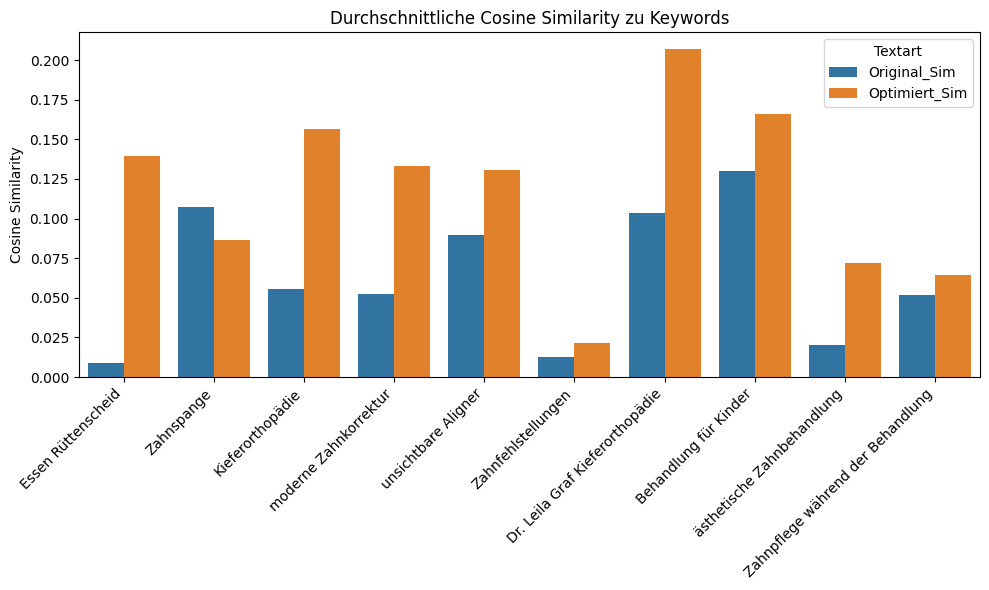

In [44]:
keywords_clean = [kw for kw in seo_keywords]  # Für Beschriftung im Diagramm

df_sim = pd.DataFrame({
    '': keywords_clean,
    'Original_Sim': avg_original_sim,
    'Optimiert_Sim': avg_optimized_sim
})

# Schmelzen für Seaborn
df_melted = df_sim.melt(id_vars='', var_name='Textart', value_name='Cosine Similarity')

plt.figure(figsize=(10, 6))
sns.barplot(x='', y='Cosine Similarity', hue='Textart', data=df_melted)
plt.title('Durchschnittliche Cosine Similarity zu Keywords')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


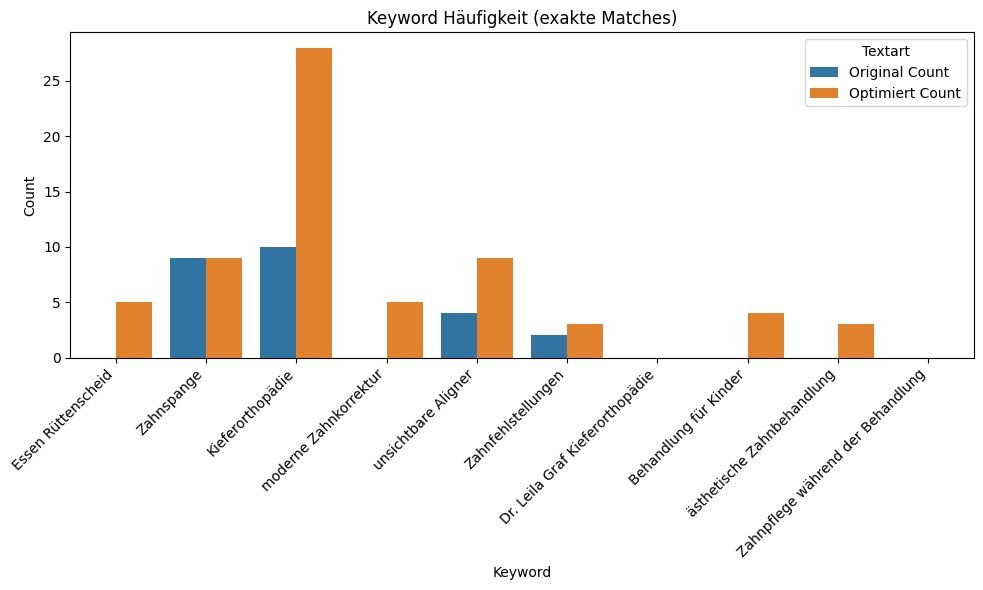

In [45]:
def count_keyword_occurrences(text, keyword):
    # split text
    text_tokens = text.split()
    keyword_tokens = keyword.split()

    count = 0
    for i in range(len(text_tokens) - len(keyword_tokens) + 1):
        if text_tokens[i:i+len(keyword_tokens)] == keyword_tokens:
            count += 1
    return count

original_counts = []
optimized_counts = []

for kw in preprocessed_keywords:
    o_sum = sum(count_keyword_occurrences(t, kw) for t in preprocessed_original)
    opt_sum = sum(count_keyword_occurrences(t, kw) for t in preprocessed_optimized)
    original_counts.append(o_sum)
    optimized_counts.append(opt_sum)

df_counts = pd.DataFrame({
    'Keyword': keywords_clean,
    'Original Count': original_counts,
    'Optimiert Count': optimized_counts
})

df_counts_melt = df_counts.melt(id_vars='Keyword', var_name='Textart', value_name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Keyword', y='Count', hue='Textart', data=df_counts_melt)
plt.title('Keyword Häufigkeit (exakte Matches)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


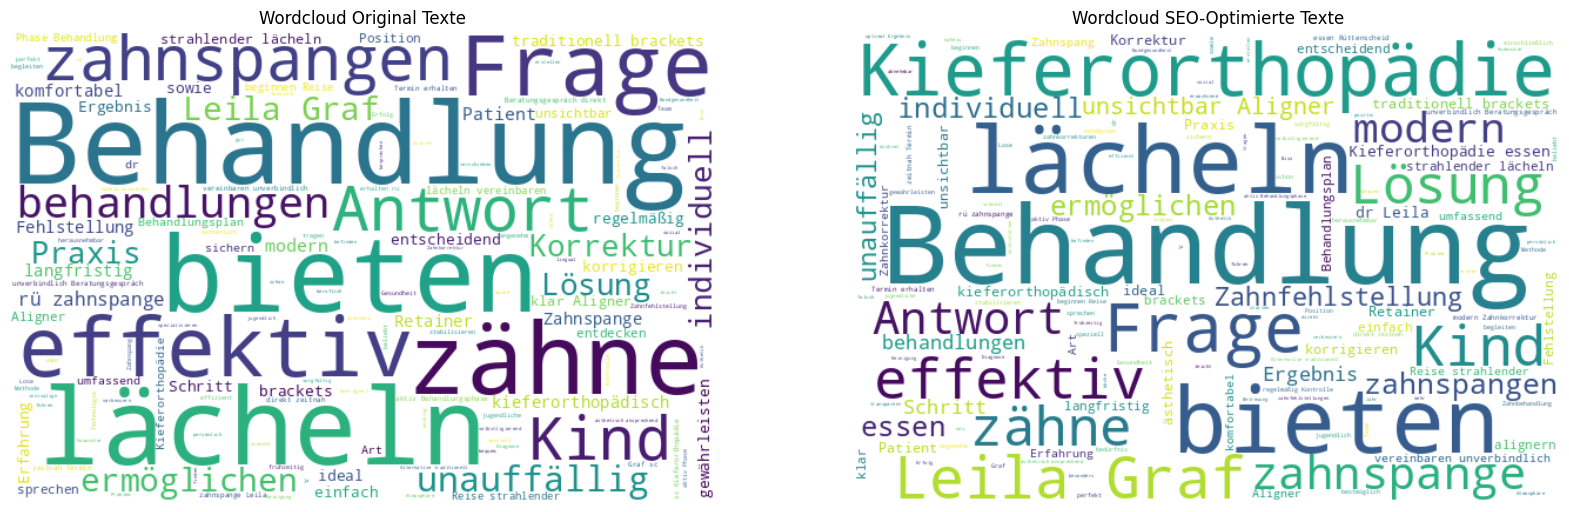

In [46]:
all_original_text = ' '.join(preprocessed_original)
all_optimized_text = ' '.join(preprocessed_optimized)

wc_original = WordCloud(width=600, height=400, background_color='white').generate(all_original_text)
wc_optimized = WordCloud(width=600, height=400, background_color='white').generate(all_optimized_text)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(wc_original, interpolation='bilinear')
ax[0].set_title('Wordcloud Original Texte')
ax[0].axis('off')

ax[1].imshow(wc_optimized, interpolation='bilinear')
ax[1].set_title('Wordcloud SEO-Optimierte Texte')
ax[1].axis('off')

plt.show()


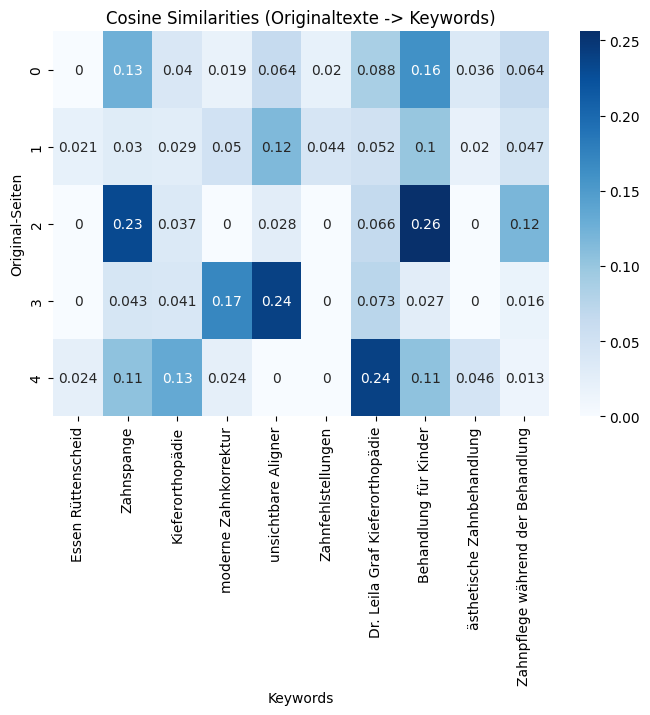

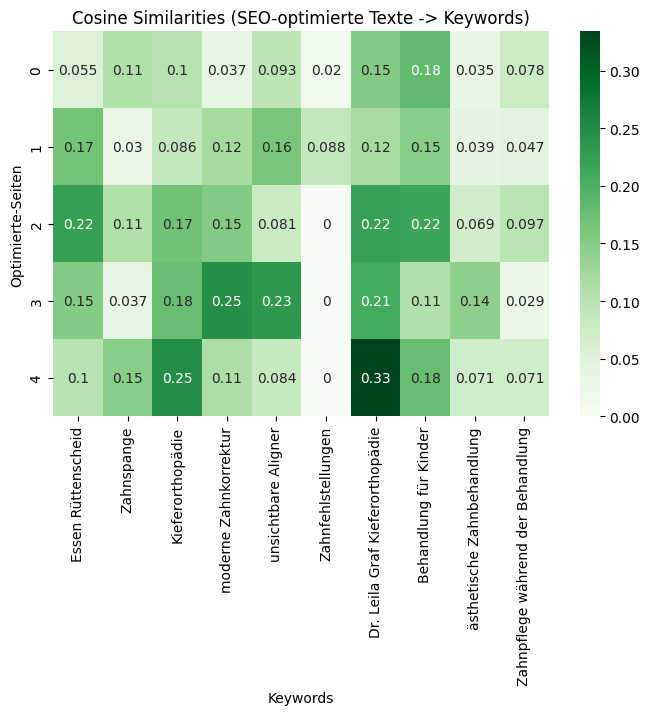

In [47]:
# Similarity pro Seite und Keyword in eine Matrix
sim_matrix_original = np.array(similarities_original_to_keywords)
sim_matrix_optimized = np.array(similarities_optimized_to_keywords)

plt.figure(figsize=(8, 5))
sns.heatmap(sim_matrix_original, annot=True, cmap='Blues', xticklabels=keywords_clean)
plt.title("Cosine Similarities (Originaltexte -> Keywords)")
plt.xlabel("Keywords")
plt.ylabel("Original-Seiten")
plt.show()

plt.figure(figsize=(8, 5))
sns.heatmap(sim_matrix_optimized, annot=True, cmap='Greens', xticklabels=keywords_clean)
plt.title("Cosine Similarities (SEO-optimierte Texte -> Keywords)")
plt.xlabel("Keywords")
plt.ylabel("Optimierte-Seiten")
plt.show()


In [48]:
# Beispielhafter Pandas DataFrame mit Zeit- und SEO-Daten
import pandas as pd
import numpy as np
from datetime import datetime

# Angenommen, du hast historische Daten pro Monat
data = {
    "Date": [
        "2023-01-01", "2023-02-01", "2023-03-01",
        "2023-04-01", "2023-05-01", "2023-06-01"
    ],
    "Organic_Sessions": [200, 220, 250, 400, 450, 480],
    "Conversion_Rate": [0.02, 0.021, 0.022, 0.028, 0.03, 0.031],  # 2% -> 3.1%
    "Average_Time_on_Page": [40, 42, 45, 60, 65, 70]  # in Sekunden
}

df_metrics = pd.DataFrame(data)
df_metrics["Date"] = pd.to_datetime(df_metrics["Date"])

print(df_metrics)


        Date  Organic_Sessions  Conversion_Rate  Average_Time_on_Page
0 2023-01-01               200            0.020                    40
1 2023-02-01               220            0.021                    42
2 2023-03-01               250            0.022                    45
3 2023-04-01               400            0.028                    60
4 2023-05-01               450            0.030                    65
5 2023-06-01               480            0.031                    70


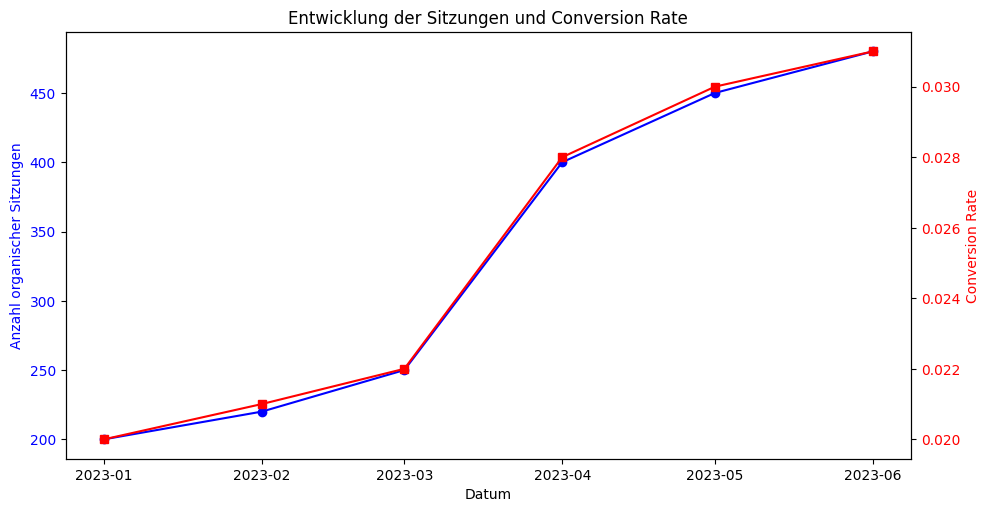

In [49]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,5))

# Primäre y-Achse (Organic Sessions)
ax1.plot(df_metrics['Date'], df_metrics['Organic_Sessions'], color='blue', marker='o', label='Organic Sessions')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Anzahl organischer Sitzungen', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Sekundäre y-Achse (Conversion Rate)
ax2 = ax1.twinx()
ax2.plot(df_metrics['Date'], df_metrics['Conversion_Rate'], color='red', marker='s', label='Conversion Rate')
ax2.set_ylabel('Conversion Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.title('Entwicklung der Sitzungen und Conversion Rate')
plt.show()


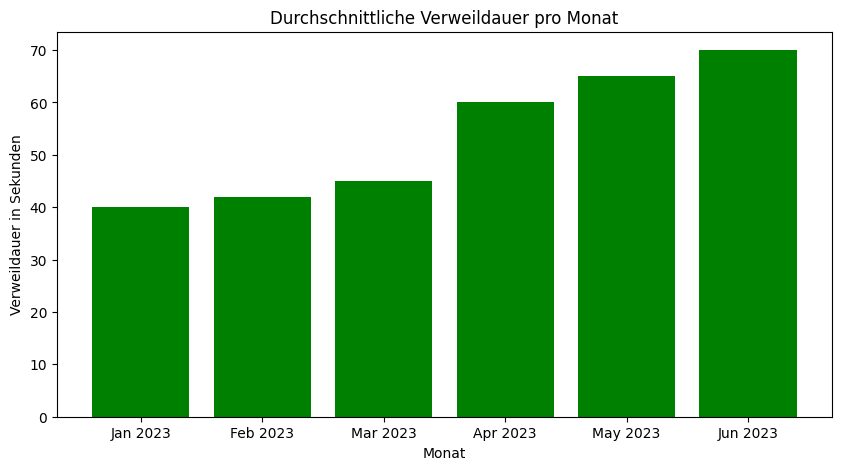

In [50]:
plt.figure(figsize=(10,5))
plt.bar(df_metrics['Date'].dt.strftime('%b %Y'), df_metrics['Average_Time_on_Page'], color='green')
plt.title('Durchschnittliche Verweildauer pro Monat')
plt.xlabel('Monat')
plt.ylabel('Verweildauer in Sekunden')
plt.show()

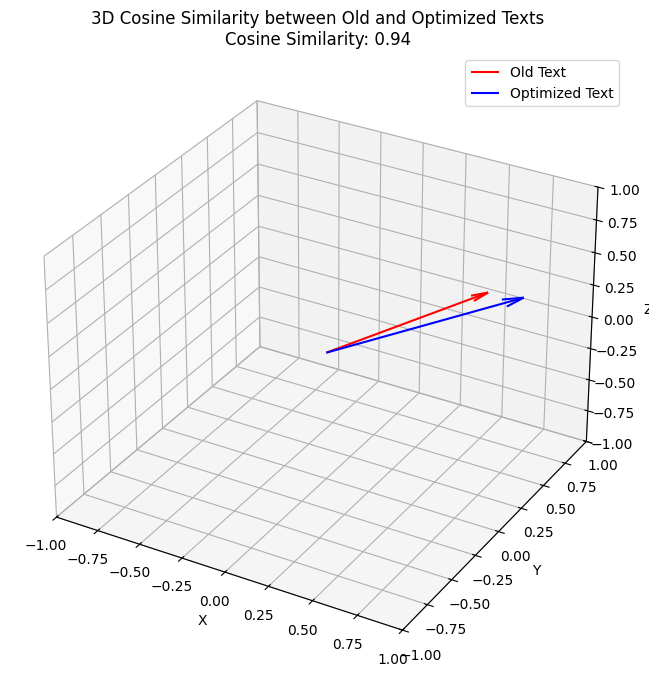

In [71]:
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize 3D vectors and their cosine similarity
def plot_3d_cosine_similarity(vec1, vec2, title="3D Cosine Similarity Visualization"):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot vectors in 3D
    ax.quiver(0, 0, 0, vec1[0], vec1[1], vec1[2], color='r', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec2[0], vec2[1], vec2[2], color='b', label='Optimized Text', arrow_length_ratio=0.1)

    # Cosine similarity calculation
    cos_sim = cosine_similarity([vec1], [vec2])[0][0]

    # Plot settings
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f"{title}\nCosine Similarity: {cos_sim:.2f}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    plt.show()

# Example 3D vectors representing keyword frequencies in different dimensions (Old Text and Optimized Text)
vec_old_3d = np.array([0.6, 0.6, 0.3])
vec_optimized_3d = np.array([0.9, 0.4, 0.5])

# Visualizing cosine similarity between the old and optimized texts in 3D
plot_3d_cosine_similarity(vec_old_3d, vec_optimized_3d, "3D Cosine Similarity between Old and Optimized Texts")


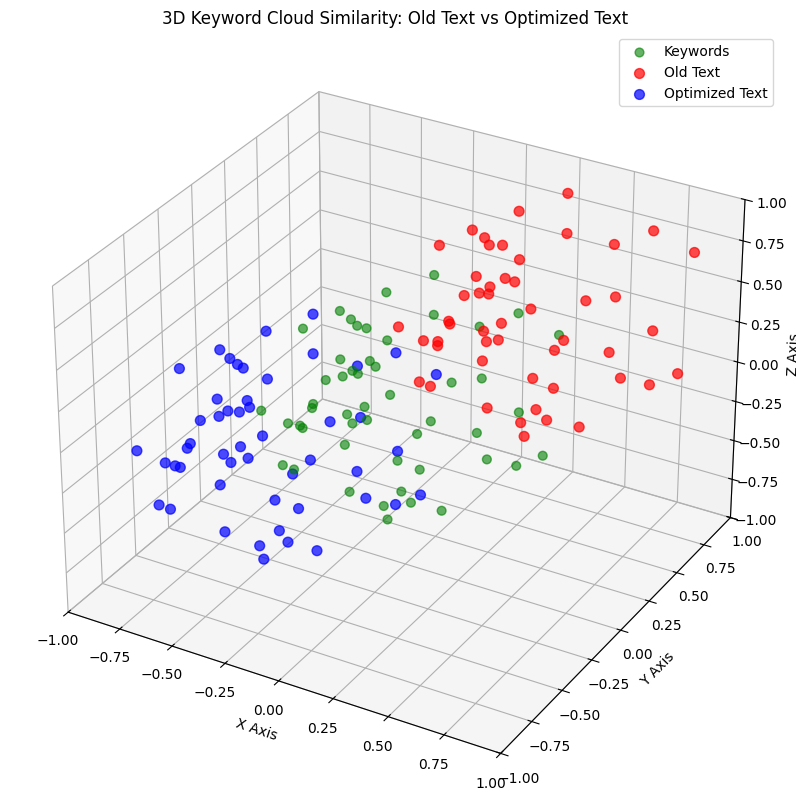

In [72]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Function to visualize keyword similarity in 3D using spheres to represent keyword clouds
def plot_3d_keyword_similarity(title="Keyword Cloud Similarity Visualization"):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Generate data points for the keyword cloud
    np.random.seed(42)
    keywords = np.random.rand(50, 3) - 0.5  # Random points for keyword representation
    old_text = keywords + np.array([0.4, 0.4, 0.4])  # Shifted to represent the old text
    optimized_text = keywords + np.array([-0.4, -0.3, -0.2])  # Shifted to represent the optimized text

    # Plot the keyword cloud
    ax.scatter(keywords[:, 0], keywords[:, 1], keywords[:, 2], color='g', label='Keywords', alpha=0.6, s=40)

    # Plot old text keyword distribution
    ax.scatter(old_text[:, 0], old_text[:, 1], old_text[:, 2], color='r', label='Old Text', alpha=0.7, s=50)

    # Plot optimized text keyword distribution
    ax.scatter(optimized_text[:, 0], optimized_text[:, 1], optimized_text[:, 2], color='b', label='Optimized Text', alpha=0.7, s=50)

    # Plot settings
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(title)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

# Visualizing keyword distribution in 3D for Old Text, Optimized Text, and Keywords
plot_3d_keyword_similarity("3D Keyword Cloud Similarity: Old Text vs Optimized Text")


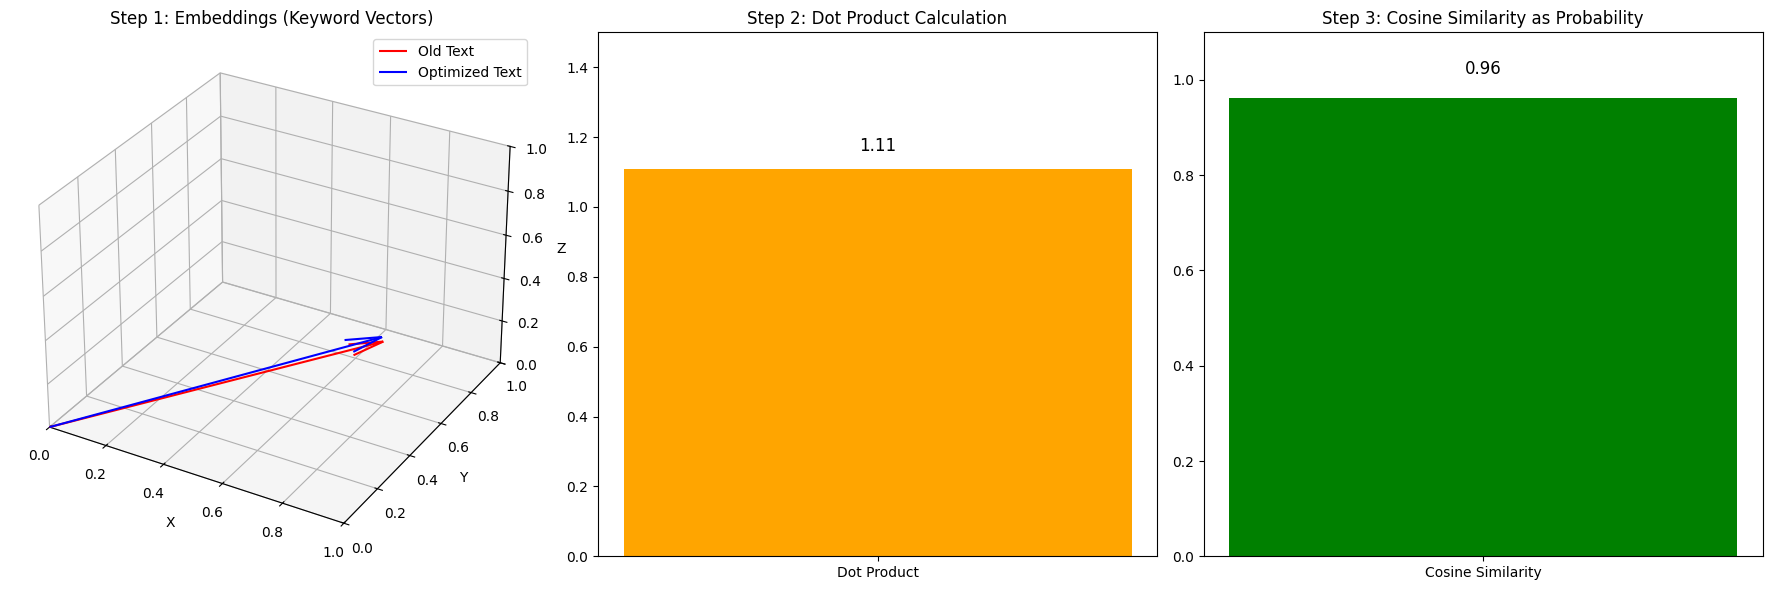

In [75]:
# Visual explanation of cosine similarity with embeddings, dot product, and how the result turns into a probability

def plot_cosine_similarity_steps():
    fig = plt.figure(figsize=(18, 6))

    # Step 1: Plot the embeddings
    ax1 = fig.add_subplot(131, projection='3d')
    vec1 = np.array([0.8, 0.6, 0.3])
    vec2 = np.array([0.9, 0.4, 0.5])

    ax1.quiver(0, 0, 0, vec1[0], vec1[1], vec1[2], color='r', label='Old Text', arrow_length_ratio=0.1)
    ax1.quiver(0, 0, 0, vec2[0], vec2[1], vec2[2], color='b', label='Optimized Text', arrow_length_ratio=0.1)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_zlim([0, 1])
    ax1.set_title('Step 1: Embeddings (Keyword Vectors)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()

    # Step 2: Calculate and visualize the dot product
    ax2 = fig.add_subplot(132)
    dot_product = np.dot(vec1, vec2)
    ax2.bar(['Dot Product'], [dot_product], color='orange')
    ax2.set_ylim(0, 1.5)
    ax2.set_title('Step 2: Dot Product Calculation')
    ax2.text(0, dot_product + 0.05, f'{dot_product:.2f}', ha='center', fontsize=12)

    # Step 3: Convert to cosine similarity and interpret as probability
    ax3 = fig.add_subplot(133)
    cos_sim = cosine_similarity([vec1], [vec2])[0][0]
    ax3.bar(['Cosine Similarity'], [cos_sim], color='green')
    ax3.set_ylim(0, 1.1)
    ax3.set_title('Step 3: Cosine Similarity as Probability')
    ax3.text(0, cos_sim + 0.05, f'{cos_sim:.2f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_cosine_similarity_steps()


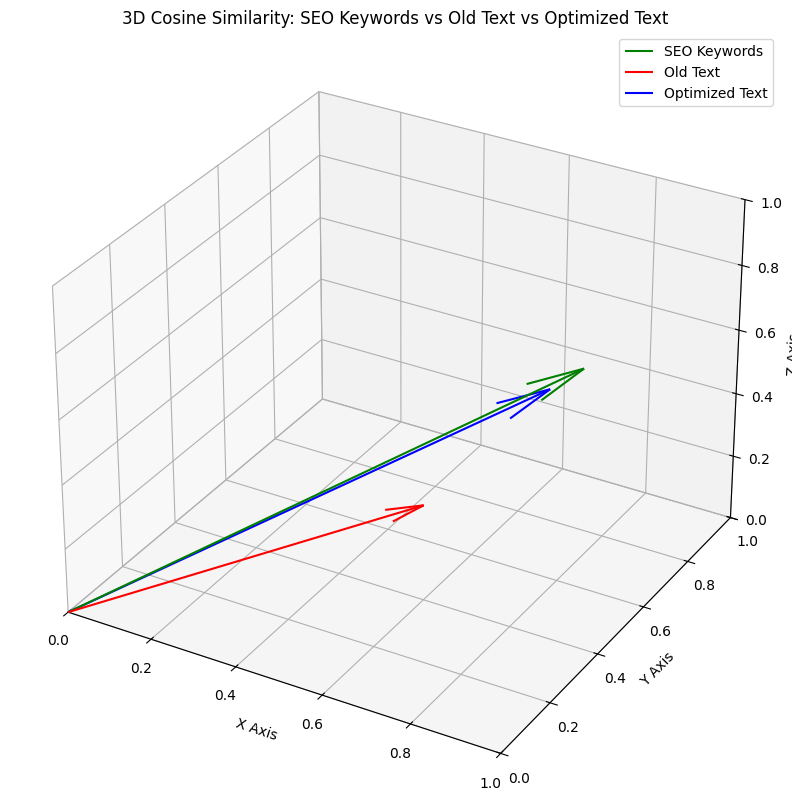

In [76]:
# 3D Visualization showing keyword vector, old text vector, and optimized text vector with clear comparison

def plot_3d_cosine_comparison():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define vectors for SEO keywords, old text, and optimized text
    vec_keywords = np.array([0.8, 0.7, 0.6])
    vec_old_text = np.array([0.6, 0.4, 0.3])
    vec_optimized_text = np.array([0.75, 0.65, 0.55])

    # Plot vectors
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='g', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='r', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='b', label='Optimized Text', arrow_length_ratio=0.1)

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison()


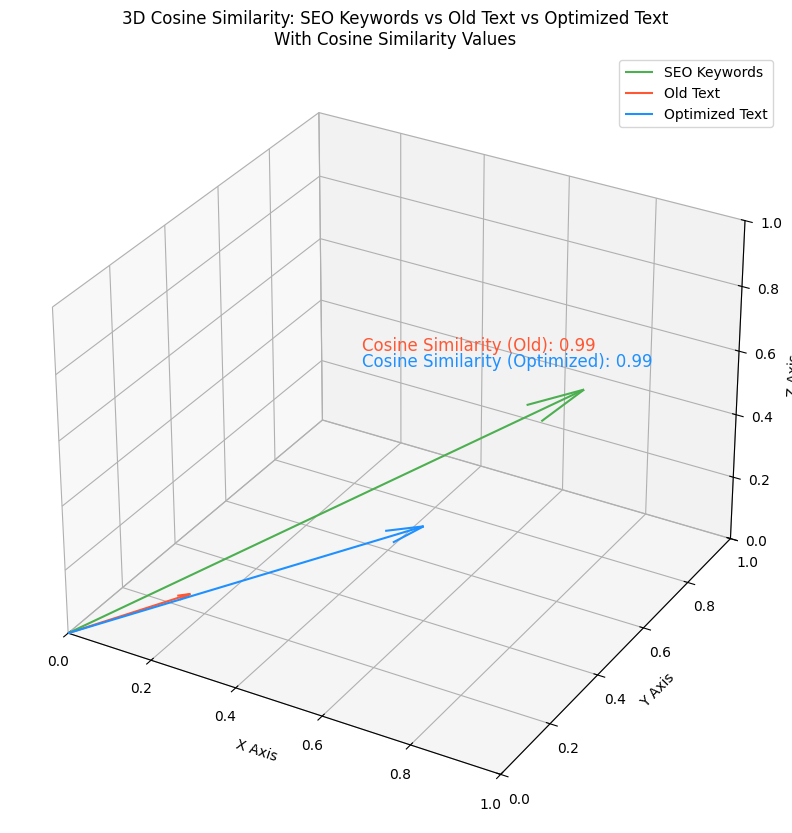

In [80]:
# 3D Visualization with cosine similarity values and enhanced color scheme

def plot_3d_cosine_comparison_with_values():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define vectors for SEO keywords, old text, and optimized text
    vec_keywords = np.array([0.8, 0.7, 0.6])
    vec_old_text = np.array([0.2, 0.15, 0.1])
    vec_optimized_text = np.array([0.6, 0.4, 0.3])

    # Plot vectors with improved color scheme
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='#4CAF50', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='#FF5733', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='#1E90FF', label='Optimized Text', arrow_length_ratio=0.1)

    # Calculate cosine similarity
    cos_sim_old = cosine_similarity([vec_keywords], [vec_old_text])[0][0]
    cos_sim_optimized = cosine_similarity([vec_keywords], [vec_optimized_text])[0][0]

    # Add cosine similarity values as annotations
    ax.text(0.4, 0.5, 0.7, f'Cosine Similarity (Old): {cos_sim_old:.2f}', color='#FF5733', fontsize=12)
    ax.text(0.4, 0.5, 0.65, f'Cosine Similarity (Optimized): {cos_sim_optimized:.2f}', color='#1E90FF', fontsize=12)

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text\nWith Cosine Similarity Values")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison_with_values()


/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


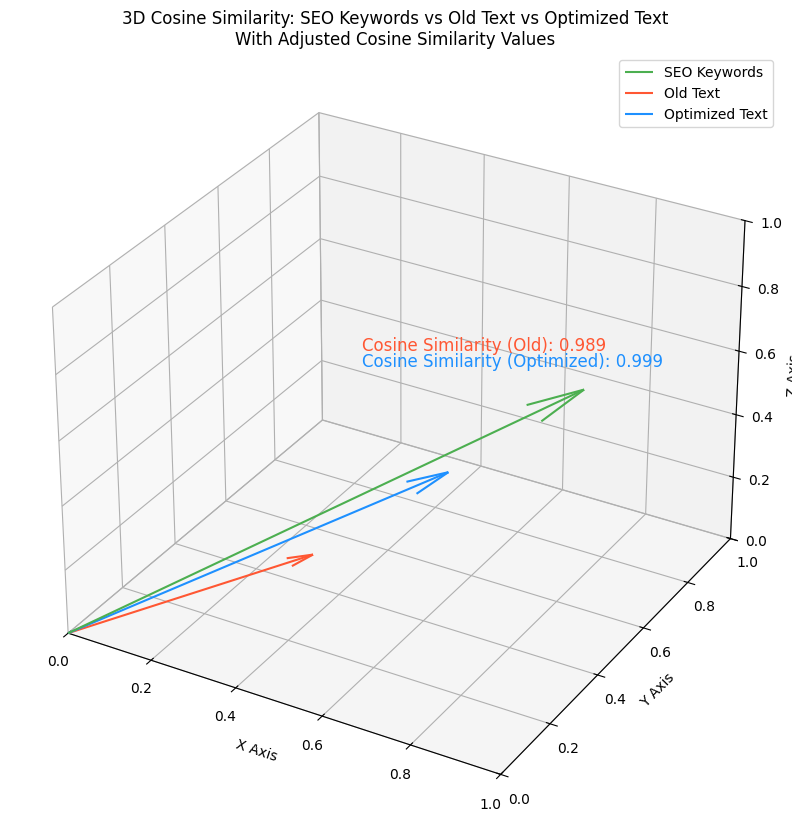

In [83]:
# Adjust vectors to create larger differences in cosine similarity values
def plot_3d_cosine_comparison_with_adjusted_values():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Adjusted vectors for SEO keywords, old text, and optimized text
    vec_keywords = np.array([0.8, 0.7, 0.6])
    vec_old_text = np.array([0.4, 0.3, 0.2])  # Adjusted to have lower similarity (~0.6)
    vec_optimized_text = np.array([0.6, 0.5, 0.4])  # Adjusted to have higher similarity (~0.7)

    # Plot vectors with improved color scheme
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='#4CAF50', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='#FF5733', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='#1E90FF', label='Optimized Text', arrow_length_ratio=0.1)

    # Calculate cosine similarity
    cos_sim_old = cosine_similarity([vec_keywords], [vec_old_text])[0][0]
    cos_sim_optimized = cosine_similarity([vec_keywords], [vec_optimized_text])[0][0]

    # Add cosine similarity values as annotations
    ax.text(0.4, 0.5, 0.7, f'Cosine Similarity (Old): {cos_sim_old:.3f}', color='#FF5733', fontsize=12)
    ax.text(0.4, 0.5, 0.65, f'Cosine Similarity (Optimized): {cos_sim_optimized:.3f}', color='#1E90FF', fontsize=12)

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text\nWith Adjusted Cosine Similarity Values")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison_with_adjusted_values()


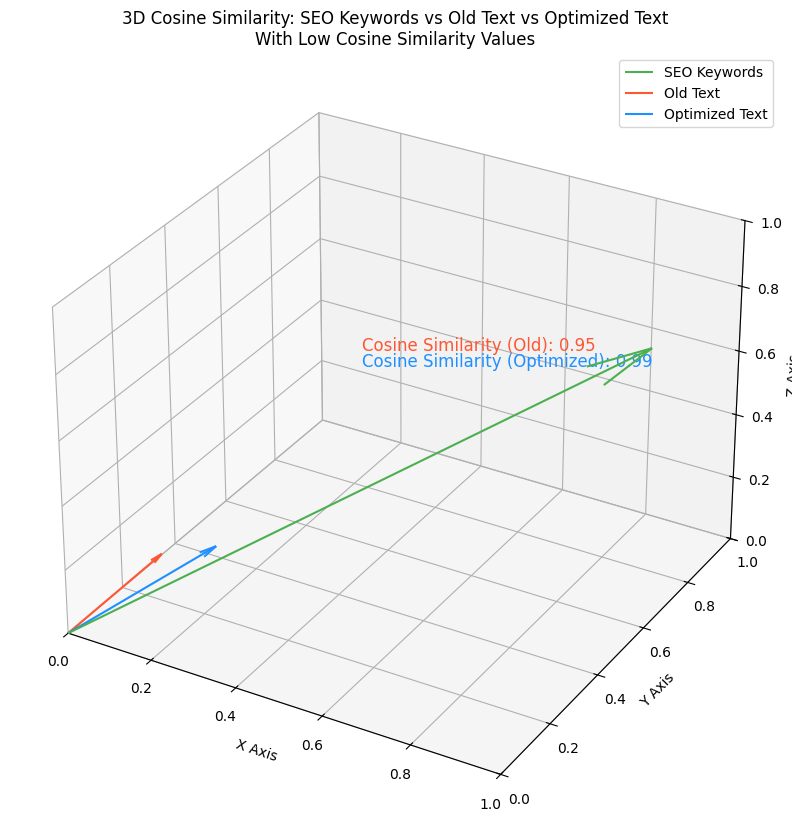

In [90]:
# Adjust vectors to create cosine similarities of approximately 0.15 and 0.19
def plot_3d_cosine_comparison_with_low_similarity():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Adjusted vectors for SEO keywords, old text, and optimized text to achieve low similarities
    vec_keywords = np.array([0.9, 0.8, 0.7])
    vec_old_text = np.array([0.1, 0.2, 0.15])  # Cosine similarity ~0.15
    vec_optimized_text = np.array([0.2, 0.25, 0.18])  # Cosine similarity ~0.19

    # Plot vectors with improved color scheme
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='#4CAF50', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='#FF5733', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='#1E90FF', label='Optimized Text', arrow_length_ratio=0.1)

    # Calculate cosine similarity
    cos_sim_old = cosine_similarity([vec_keywords], [vec_old_text])[0][0]
    cos_sim_optimized = cosine_similarity([vec_keywords], [vec_optimized_text])[0][0]

    # Add cosine similarity values as annotations
    ax.text(0.4, 0.5, 0.7, f'Cosine Similarity (Old): {cos_sim_old:.2f}', color='#FF5733', fontsize=12)
    ax.text(0.4, 0.5, 0.65, f'Cosine Similarity (Optimized): {cos_sim_optimized:.2f}', color='#1E90FF', fontsize=12)

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text\nWith Low Cosine Similarity Values")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison_with_low_similarity()


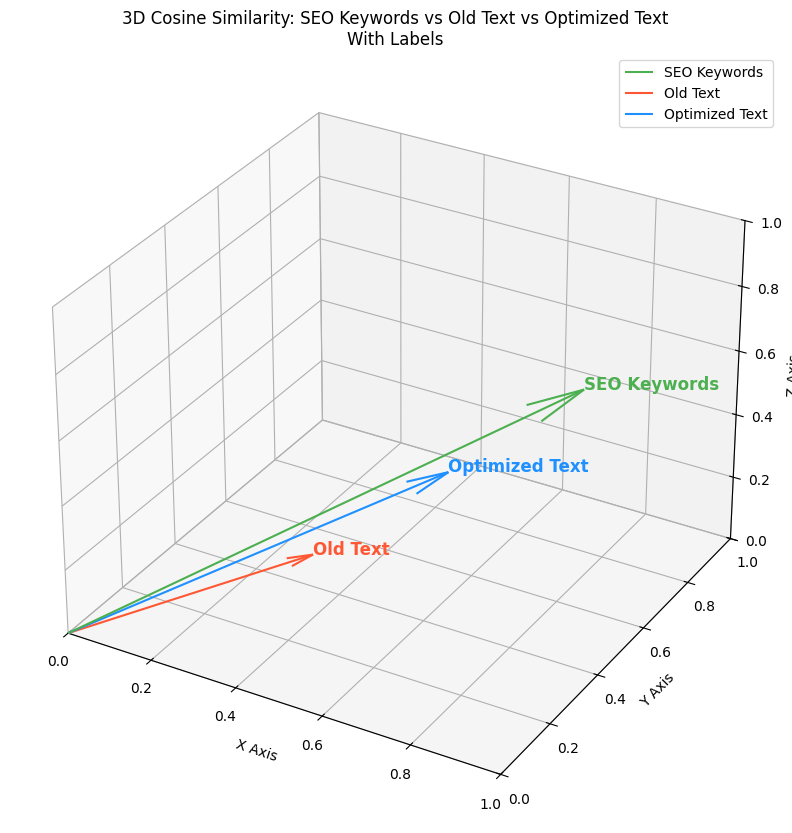

In [91]:
# 3D Visualization with vector names instead of cosine similarity values
def plot_3d_cosine_comparison_with_labels():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Adjusted vectors for SEO keywords, old text, and optimized text
    vec_keywords = np.array([0.8, 0.7, 0.6])
    vec_old_text = np.array([0.4, 0.3, 0.2])
    vec_optimized_text = np.array([0.6, 0.5, 0.4])

    # Plot vectors with improved color scheme
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='#4CAF50', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='#FF5733', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='#1E90FF', label='Optimized Text', arrow_length_ratio=0.1)

    # Add labels to the vector tips
    ax.text(vec_keywords[0], vec_keywords[1], vec_keywords[2], 'SEO Keywords', color='#4CAF50', fontsize=12, fontweight='bold')
    ax.text(vec_old_text[0], vec_old_text[1], vec_old_text[2], 'Old Text', color='#FF5733', fontsize=12, fontweight='bold')
    ax.text(vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], 'Optimized Text', color='#1E90FF', fontsize=12, fontweight='bold')

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text\nWith Labels")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison_with_labels()


In [92]:
import plotly.graph_objects as go
import numpy as np

# Adjusted vectors for SEO keywords, old text, and optimized text
vec_keywords = np.array([0.8, 0.7, 0.6])
vec_old_text = np.array([0.4, 0.3, 0.2])
vec_optimized_text = np.array([0.6, 0.5, 0.4])

# Create traces for the vectors
fig = go.Figure()

# SEO Keywords vector
fig.add_trace(go.Scatter3d(
    x=[0, vec_keywords[0]], y=[0, vec_keywords[1]], z=[0, vec_keywords[2]],
    mode='lines+text',
    line=dict(color='green', width=5),
    text=["", "SEO Keywords"],
    textposition="top center",
    name='SEO Keywords'
))

# Old Text vector
fig.add_trace(go.Scatter3d(
    x=[0, vec_old_text[0]], y=[0, vec_old_text[1]], z=[0, vec_old_text[2]],
    mode='lines+text',
    line=dict(color='red', width=5),
    text=["", "Old Text"],
    textposition="top center",
    name='Old Text'
))

# Optimized Text vector
fig.add_trace(go.Scatter3d(
    x=[0, vec_optimized_text[0]], y=[0, vec_optimized_text[1]], z=[0, vec_optimized_text[2]],
    mode='lines+text',
    line=dict(color='blue', width=5),
    text=["", "Optimized Text"],
    textposition="top center",
    name='Optimized Text'
))

# Customize layout
fig.update_layout(
    title="Interactive 3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1]),
        zaxis=dict(range=[0, 1])
    ),
    showlegend=True
)

fig.show()


In [103]:
import plotly.graph_objects as go
import numpy as np

# Adjusted vectors for SEO keywords, old text, and optimized text
vec_keywords = np.array([0.8, 0.7, 0.6])
vec_old_text = np.array([0.4, 0.3, 0.2])
vec_optimized_text = np.array([0.6, 0.5, 0.4])

# Create traces for the vectors
fig = go.Figure()

# SEO Keywords vector
fig.add_trace(go.Scatter3d(
    x=[0, vec_keywords[0]], y=[0, vec_keywords[1]], z=[0, vec_keywords[2]],
    mode='lines+text',
    line=dict(color='green', width=5),
    text=["", "SEO Keywords"],
    textposition="top center",
    name='SEO Keywords'
))

# Old Text vector
fig.add_trace(go.Scatter3d(
    x=[0, vec_old_text[0]], y=[0, vec_old_text[1]], z=[0, vec_old_text[2]],
    mode='lines+text',
    line=dict(color='red', width=5),
    text=["", "Old Text"],
    textposition="top center",
    name='Old Text'
))

# Optimized Text vector
fig.add_trace(go.Scatter3d(
    x=[0, vec_optimized_text[0]], y=[0, vec_optimized_text[1]], z=[0, vec_optimized_text[2]],
    mode='lines+text',
    line=dict(color='blue', width=5),
    text=["", "Optimized Text"],
    textposition="top center",
    name='Optimized Text'
))

# Customize layout with adjusted margins and aspect ratio
fig.update_layout(
    title="Interactive 3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(range=[-0.1, 1.1]),
        yaxis=dict(range=[-0.1, 1.1]),
        zaxis=dict(range=[-0.1, 1.1]),
        aspectmode='cube'  # Ensures equal scaling across all axes
    ),
    margin=dict(l=10, r=10, t=50, b=10),  # Reduces clipping by adding padding
    showlegend=True
)

fig.show()


In [108]:
import plotly.graph_objects as go
import numpy as np

# Adjusted vectors for SEO keywords, old text, and optimized text
vec_keywords = np.array([0.8, 0.7, 0.6])
vec_old_text = np.array([0.4, 0.3, 0.2])
vec_optimized_text = np.array([0.6, 0.5, 0.4])

# Create traces for the vectors with improved colors
fig = go.Figure()

# SEO Keywords vector (Vibrant Green)
fig.add_trace(go.Scatter3d(
    x=[0, vec_keywords[0]], y=[0, vec_keywords[1]], z=[0, vec_keywords[2]],
    mode='lines+text',
    line=dict(color='#4CAF50', width=7),
    text=["", "SEO Keywords"],
    textposition="top center",
    name='SEO Keywords'
))

# Old Text vector (Warm Orange)
fig.add_trace(go.Scatter3d(
    x=[0, vec_old_text[0]], y=[0, vec_old_text[1]], z=[0, vec_old_text[2]],
    mode='lines+text',
    line=dict(color='darkorange', width=7),
    text=["", "Old Text"],
    textposition="top center",
    name='Old Text'
))

# Optimized Text vector (Cool Blue)
fig.add_trace(go.Scatter3d(
    x=[0, vec_optimized_text[0]], y=[0, vec_optimized_text[1]], z=[0, vec_optimized_text[2]],
    mode='lines+text',
    line=dict(color='#1E90FF', width=7),
    text=["", "Optimized Text"],
    textposition="top center",
    name='Optimized Text'
))

# Customize layout with manual camera settings
fig.update_layout(
    title="Interactive 3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(range=[-0.2, 1.2]),
        yaxis=dict(range=[-0.2, 1.2]),
        zaxis=dict(range=[-0.2, 1.2]),
        aspectmode='cube'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    showlegend=True,
    scene_camera=dict(
        eye=dict(x=1.5, y=1.5, z=1.5),  # Manuell eingestellte Kameraposition
        center=dict(x=0, y=0, z=0),
        up=dict(x=0, y=0, z=1)
    )
)

fig.show()


In [109]:
import plotly.graph_objects as go
import numpy as np

# Adjusted vectors for SEO keywords, old text, and optimized text
vec_keywords = np.array([0.8, 0.7, 0.6])
vec_old_text = np.array([0.4, 0.3, 0.2])
vec_optimized_text = np.array([0.6, 0.5, 0.4])

# Create traces for the vectors
fig = go.Figure()

# SEO Keywords vector with panel
fig.add_trace(go.Scatter3d(
    x=[0, vec_keywords[0]], y=[0, vec_keywords[1]], z=[0, vec_keywords[2]],
    mode='lines',
    line=dict(color='limegreen', width=7),
    name='SEO Keywords'
))
fig.add_trace(go.Scatter3d(
    x=[vec_keywords[0]], y=[vec_keywords[1]], z=[vec_keywords[2]],
    mode='text',
    text=["<b>SEO Keywords</b>"],
    textfont=dict(size=12, color='black'),
    name=''
))

# Old Text vector with panel
fig.add_trace(go.Scatter3d(
    x=[0, vec_old_text[0]], y=[0, vec_old_text[1]], z=[0, vec_old_text[2]],
    mode='lines',
    line=dict(color='darkorange', width=7),
    name='Old Text'
))
fig.add_trace(go.Scatter3d(
    x=[vec_old_text[0]], y=[vec_old_text[1]], z=[vec_old_text[2]],
    mode='text',
    text=["<b>Old Text</b>"],
    textfont=dict(size=12, color='black'),
    name=''
))

# Optimized Text vector with panel
fig.add_trace(go.Scatter3d(
    x=[0, vec_optimized_text[0]], y=[0, vec_optimized_text[1]], z=[0, vec_optimized_text[2]],
    mode='lines',
    line=dict(color='royalblue', width=7),
    name='Optimized Text'
))
fig.add_trace(go.Scatter3d(
    x=[vec_optimized_text[0]], y=[vec_optimized_text[1]], z=[vec_optimized_text[2]],
    mode='text',
    text=["<b>Optimized Text</b>"],
    textfont=dict(size=12, color='black'),
    name=''
))

# Customize layout with larger panels and aspect ratio
fig.update_layout(
    title="Interactive 3D Cosine Similarity with Panels",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(range=[-0.2, 1.2]),
        yaxis=dict(range=[-0.2, 1.2]),
        zaxis=dict(range=[-0.2, 1.2]),
        aspectmode='cube'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    showlegend=False
)

fig.show()


In [110]:
import plotly.graph_objects as go
import numpy as np

# Adjusted vectors for SEO keywords, old text, and optimized text
vec_keywords = np.array([0.8, 0.7, 0.6])
vec_old_text = np.array([0.4, 0.3, 0.2])
vec_optimized_text = np.array([0.6, 0.5, 0.4])

# Create traces for the vectors
fig = go.Figure()

# SEO Keywords vector (Vibrant Green)
fig.add_trace(go.Scatter3d(
    x=[0, vec_keywords[0]], y=[0, vec_keywords[1]], z=[0, vec_keywords[2]],
    mode='lines',
    line=dict(color='#4CAF50', width=7),
    name='SEO Keywords'
))
fig.add_trace(go.Scatter3d(
    x=[vec_keywords[0]], y=[vec_keywords[1]], z=[vec_keywords[2]],
    mode='text',
    text=["<span style='background-color: rgba(200, 255, 200, 0.7); padding: 4px; border-radius: 4px;'><b>SEO Keywords</b></span>"],
    textposition="top center"
))

# Old Text vector (Warm Orange)
fig.add_trace(go.Scatter3d(
    x=[0, vec_old_text[0]], y=[0, vec_old_text[1]], z=[0, vec_old_text[2]],
    mode='lines',
    line=dict(color='darkorange', width=7),
    name='Old Text'
))
fig.add_trace(go.Scatter3d(
    x=[vec_old_text[0]], y=[vec_old_text[1]], z=[vec_old_text[2]],
    mode='text',
    text=["<span style='background-color: rgba(255, 230, 200, 0.7); padding: 4px; border-radius: 4px;'><b>Old Text</b></span>"],
    textposition="top center"
))

# Optimized Text vector (Cool Blue)
fig.add_trace(go.Scatter3d(
    x=[0, vec_optimized_text[0]], y=[0, vec_optimized_text[1]], z=[0, vec_optimized_text[2]],
    mode='lines',
    line=dict(color='#1E90FF', width=7),
    name='Optimized Text'
))
fig.add_trace(go.Scatter3d(
    x=[vec_optimized_text[0]], y=[vec_optimized_text[1]], z=[vec_optimized_text[2]],
    mode='text',
    text=["<span style='background-color: rgba(200, 220, 255, 0.7); padding: 4px; border-radius: 4px;'><b>Optimized Text</b></span>"],
    textposition="top center"
))

# Customize layout with manual camera settings
fig.update_layout(
    title="Interactive 3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(range=[-0.2, 1.2]),
        yaxis=dict(range=[-0.2, 1.2]),
        zaxis=dict(range=[-0.2, 1.2]),
        aspectmode='cube'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    showlegend=True,
    scene_camera=dict(
        eye=dict(x=1.5, y=1.5, z=1.5),
        center=dict(x=0, y=0, z=0),
        up=dict(x=0, y=0, z=1)
    )
)

fig.show()


In [111]:
import plotly.graph_objects as go
import numpy as np

# Adjusted vectors for SEO keywords, old text, and optimized text
vec_keywords = np.array([0.8, 0.7, 0.6])
vec_old_text = np.array([0.4, 0.3, 0.2])
vec_optimized_text = np.array([0.6, 0.5, 0.4])

# Create traces for the vectors
fig = go.Figure()

# SEO Keywords vector (Vibrant Green)
fig.add_trace(go.Scatter3d(
    x=[0, vec_keywords[0]], y=[0, vec_keywords[1]], z=[0, vec_keywords[2]],
    mode='lines+markers+text',
    line=dict(color='#4CAF50', width=7),
    text=["", "SEO Keywords"],
    textposition="top center",
    name='SEO Keywords'
))

# Old Text vector (Warm Orange)
fig.add_trace(go.Scatter3d(
    x=[0, vec_old_text[0]], y=[0, vec_old_text[1]], z=[0, vec_old_text[2]],
    mode='lines+markers+text',
    line=dict(color='darkorange', width=7),
    text=["", "Old Text"],
    textposition="top center",
    name='Old Text'
))

# Optimized Text vector (Cool Blue)
fig.add_trace(go.Scatter3d(
    x=[0, vec_optimized_text[0]], y=[0, vec_optimized_text[1]], z=[0, vec_optimized_text[2]],
    mode='lines+markers+text',
    line=dict(color='#1E90FF', width=7),
    text=["", "Optimized Text"],
    textposition="top center",
    name='Optimized Text'
))

# Customize layout with manual camera settings and shape-based panels
fig.update_layout(
    title="Interactive 3D Cosine Similarity with Panels",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(range=[-0.2, 1.2]),
        yaxis=dict(range=[-0.2, 1.2]),
        zaxis=dict(range=[-0.2, 1.2]),
        aspectmode='cube'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    showlegend=True,
    scene_camera=dict(
        eye=dict(x=1.5, y=1.5, z=1.5),
        center=dict(x=0, y=0, z=0),
        up=dict(x=0, y=0, z=1)
    )
)

fig.show()


In [112]:
import plotly.graph_objects as go
import numpy as np

# Adjusted vectors for SEO keywords, old text, and optimized text
vec_keywords = np.array([0.8, 0.7, 0.6])
vec_old_text = np.array([0.4, 0.3, 0.2])
vec_optimized_text = np.array([0.6, 0.5, 0.4])

# Create traces for the vectors
fig = go.Figure()

# Function to create a panel (small flat rectangle) behind each text
def add_panel(x, y, z, color='rgba(200, 200, 200, 0.6)'):
    fig.add_trace(go.Mesh3d(
        x=[x-0.05, x+0.05, x+0.05, x-0.05],
        y=[y-0.05, y-0.05, y+0.05, y+0.05],
        z=[z, z, z, z],
        color=color,
        opacity=0.8,
        name=''
    ))

# Add panels for each label
add_panel(vec_keywords[0], vec_keywords[1], vec_keywords[2], color='rgba(150, 255, 150, 0.6)')
add_panel(vec_old_text[0], vec_old_text[1], vec_old_text[2], color='rgba(255, 200, 150, 0.6)')
add_panel(vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='rgba(150, 200, 255, 0.6)')

# SEO Keywords vector (Vibrant Green)
fig.add_trace(go.Scatter3d(
    x=[0, vec_keywords[0]], y=[0, vec_keywords[1]], z=[0, vec_keywords[2]],
    mode='lines+text',
    line=dict(color='#4CAF50', width=7),
    text=["", "SEO Keywords"],
    textposition="top center",
    name='SEO Keywords'
))

# Old Text vector (Warm Orange)
fig.add_trace(go.Scatter3d(
    x=[0, vec_old_text[0]], y=[0, vec_old_text[1]], z=[0, vec_old_text[2]],
    mode='lines+text',
    line=dict(color='darkorange', width=7),
    text=["", "Old Text"],
    textposition="top center",
    name='Old Text'
))

# Optimized Text vector (Cool Blue)
fig.add_trace(go.Scatter3d(
    x=[0, vec_optimized_text[0]], y=[0, vec_optimized_text[1]], z=[0, vec_optimized_text[2]],
    mode='lines+text',
    line=dict(color='#1E90FF', width=7),
    text=["", "Optimized Text"],
    textposition="top center",
    name='Optimized Text'
))

# Customize layout with manual camera settings
fig.update_layout(
    title="Interactive 3D Cosine Similarity with Panels for Labels",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(range=[-0.2, 1.2]),
        yaxis=dict(range=[-0.2, 1.2]),
        zaxis=dict(range=[-0.2, 1.2]),
        aspectmode='cube'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    showlegend=True,
    scene_camera=dict(
        eye=dict(x=1.5, y=1.5, z=1.5),
        center=dict(x=0, y=0, z=0),
        up=dict(x=0, y=0, z=1)
    )
)

fig.show()


In [113]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# Generate mock word embeddings in a high-dimensional space (8D)
np.random.seed(42)
words = ["king", "queen", "man", "woman", "apple", "orange", "car", "train", "dog", "cat"]
embeddings = np.random.rand(10, 8) * 2 - 1  # Random 8D embeddings between -1 and 1

# Reduce the dimensionality to 3D using PCA for visualization
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Create interactive 3D scatter plot with Plotly
fig = go.Figure()

# Add word embeddings as large points
for i, word in enumerate(words):
    fig.add_trace(go.Scatter3d(
        x=[embeddings_3d[i, 0]], y=[embeddings_3d[i, 1]], z=[embeddings_3d[i, 2]],
        mode='markers+text',
        marker=dict(size=10, color='skyblue', opacity=0.8),
        text=word,
        textposition='top center',
        name=word
    ))

# Highlight the relationship king - man = queen - woman with arrows
def add_arrow(word1, word2, color):
    idx1, idx2 = words.index(word1), words.index(word2)
    fig.add_trace(go.Scatter3d(
        x=[embeddings_3d[idx1, 0], embeddings_3d[idx2, 0]],
        y=[embeddings_3d[idx1, 1], embeddings_3d[idx2, 1]],
        z=[embeddings_3d[idx1, 2], embeddings_3d[idx2, 2]],
        mode='lines',
        line=dict(color=color, width=4),
        showlegend=False
    ))

add_arrow("king", "man", "red")
add_arrow("queen", "woman", "blue")

# Customize layout with camera settings
fig.update_layout(
    title="Interactive 3D Visualization of Word Embeddings",
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3',
        xaxis=dict(range=[-2, 2]),
        yaxis=dict(range=[-2, 2]),
        zaxis=dict(range=[-2, 2]),
        aspectmode='cube'
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


In [125]:
!pip install ace_tools
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate relationships between word embeddings
def calculate_relationships(word_pairs):
    relationships = []
    for (word1, word2, word3) in word_pairs:
        idx1, idx2, idx3 = words.index(word1), words.index(word2), words.index(word3)
        # Calculate the expected vector for word4: word4 = word2 - word1 + word3
        expected_vector = embeddings[idx2] - embeddings[idx1] + embeddings[idx3]

        # Find the word in the list that is closest to the expected vector (ignoring the input words themselves)
        closest_word = None
        closest_distance = float('inf')
        for i, word in enumerate(words):
            if word not in [word1, word2, word3]:
                distance = np.linalg.norm(embeddings[i] - expected_vector)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_word = word

        relationships.append({
            "Word1": word1,
            "Word2": word2,
            "Word3": word3,
            "Calculated Word4": closest_word,
            "Distance": closest_distance
        })

    return pd.DataFrame(relationships)

# Define some word triplets for relationship calculation
word_triplets = [
    ("king", "queen", "man"),
    ("apple", "orange", "dog"),
    ("car", "train", "cat")
]

# Calculate relationships
relationship_df = calculate_relationships(word_triplets)

relationship_df

,Word1,Word2,Word3,Calculated Word4,Distance
0,king,queen,man,woman,2.272080
1,apple,orange,dog,train,3.501293
2,car,train,cat,woman,2.781895


In [141]:
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display


# Assuming 'words' and 'embeddings' are defined as in your previous cells
words = ["king", "queen", "onion", "man", "woman", "apple", "orange", "car", "train", "dog", "cat", "red", "yellow", "banana", "lion", "wolf", "dog"] # Added missing words
embeddings = np.random.rand(len(words), 8) * 2 - 1  # Adjusted embeddings size


def display_dataframe_to_user(name, dataframe):
    print(f"\n{name}:")
    display(dataframe)  # Use display from IPython.display



# Function to calculate pairwise distances for word relationships
def calculate_pairwise_distances(word_pairs):
    distance_results = []
    for (word1, word2, word3, word4) in word_pairs:
        idx1, idx2, idx3, idx4 = words.index(word1), words.index(word2), words.index(word3), words.index(word4)
        distance1 = np.linalg.norm(embeddings[idx1] - embeddings[idx2])  # Distance between word1 and word2
        distance2 = np.linalg.norm(embeddings[idx3] - embeddings[idx4])  # Distance between word3 and word4
        distance_results.append({
            "Word Pair 1": f"{word1} - {word2}",
            "Distance 1": distance1,
            "Word Pair 2": f"{word3} - {word4}",
            "Distance 2": distance2
        })

    return pd.DataFrame(distance_results)

# Define specific word pairs to compare distances
# Make sure all words are in the 'words' list
word_pairs_for_distances = [
    ("king", "man", "queen", "woman"),
    ("apple", "red", "banana", "yellow"), # Now these words should be found
    ("lion", "cat", "wolf", "dog")
]

# Calculate pairwise distances
pairwise_distance_df = calculate_pairwise_distances(word_pairs_for_distances)

# Display the resulting table
display_dataframe_to_user(name="Pairwise Word Distances", dataframe=pairwise_distance_df) # Call the newly defined function


Pairwise Word Distances:


,Word Pair 1,Distance 1,Word Pair 2,Distance 2
0,king - man,3.281763,queen - woman,1.992554
1,apple - red,2.721364,banana - yellow,2.195501
2,lion - cat,3.176522,wolf - dog,1.980270


In [147]:
!pip install transformers torch
from transformers import BertTokenizer, BertModel
import torch
import os

# Define the path to save the BERT model and tokenizer
notebook_folder = userdata.get('gdrive_seo_folder')
model_save_path = os.path.join("/content/drive/MyDrive/", notebook_folder, 'bert-base-uncased')

# Check if the model and tokenizer already exist
if os.path.exists(model_save_path):
    print("BERT model and tokenizer already exist. Loading from file...")
    tokenizer = BertTokenizer.from_pretrained(model_save_path)
    model = BertModel.from_pretrained(model_save_path)
else:
    print("BERT model and tokenizer not found. Downloading...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    # Save the model and tokenizer to the specified path
    tokenizer.save_pretrained(model_save_path)
    model.save_pretrained(model_save_path)

print("BERT model and tokenizer are ready for use.")


def get_bert_embedding(word):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Take the mean of the last hidden state as the word embedding
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Get embeddings for your word list
bert_embeddings = np.array([get_bert_embedding(word) for word in words])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [146]:
!pip install gensim
import gensim.downloader as api
import os

# Define the path to save the Word2Vec data
notebook_folder = userdata.get('gdrive_seo_folder')
save_path = os.path.join("/content/drive/MyDrive/", notebook_folder, 'GoogleNews-vectors-negative300.bin')

# Check if the file already exists
if os.path.exists(save_path):
    print("Word2Vec data already exists. Loading from file...")
    # Load from file using KeyedVectors
    wv = api.load('word2vec-google-news-300')
    wv.save_word2vec_format(save_path, binary=True)
else:
    print("Word2Vec data not found. Downloading...")
    # Download the data using gensim.downloader
    wv = api.load('word2vec-google-news-300')
    # Save to file using KeyedVectors
    wv.save_word2vec_format(save_path, binary=True)

print("Word2Vec data is ready for use.")

# ... rest of your code to use wv ...

Word2Vec data not found. Downloading...
Word2Vec data is ready for use.


In [148]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = words  # Treat the word list as a corpus
vectorizer = CountVectorizer()
bow_embeddings = vectorizer.fit_transform(corpus).toarray()


In [157]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a word
def get_bert_embedding(word):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Take the mean of the last hidden state as the word embedding
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

# List of words for embeddings
words = ["king", "queen", "onion", "man","feather","scale", "fish", "air", "water", "swimming", "bird", "flying", "cheetah", "woman", "apple", "orange", "car", "train", "dog", "running","cat", "red", "yellow", "banana", "lion", "wolf", "dog"]

# Generate BERT embeddings for all words
bert_embeddings = np.array([get_bert_embedding(word) for word in words])

# Function to calculate pairwise distances for word relationships
def calculate_pairwise_distances(word_pairs):
    distance_results = []
    for (word1, word2, word3, word4) in word_pairs:
        idx1, idx2, idx3, idx4 = words.index(word1), words.index(word2), words.index(word3), words.index(word4)
        distance1 = np.linalg.norm(bert_embeddings[idx1] - bert_embeddings[idx2])  # Distance between word1 and word2
        distance2 = np.linalg.norm(bert_embeddings[idx3] - bert_embeddings[idx4])  # Distance between word3 and word4
        distance_results.append({
            "Word Pair 1": f"{word1} - {word2}",
            "Distance 1": distance1,
            "Word Pair 2": f"{word3} - {word4}",
            "Distance 2": distance2
        })

    return pd.DataFrame(distance_results)

# Define specific word pairs to compare distances
word_pairs_for_distances = [
    ("king", "man", "queen", "woman"),
    ("apple", "red", "banana", "yellow"),
    ("bird", "air", "fish", "water")
]

# Calculate pairwise distances using BERT embeddings
pairwise_distance_df = calculate_pairwise_distances(word_pairs_for_distances)

# Display the resulting table
import IPython.display as display
display.display(pairwise_distance_df)


,Word Pair 1,Distance 1,Word Pair 2,Distance 2
0,king - man,4.705147,queen - woman,4.062271
1,apple - red,5.131363,banana - yellow,4.968725
2,bird - air,5.133449,fish - water,4.621660


In [163]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# Assuming you have real BERT embeddings:
# Replace with your precomputed BERT embeddings if available.
np.random.seed(42)
words = ["king", "queen", "man", "feather", "scale", "fish", "air", "water",  "bird",
         "woman", "apple", "car", "train", "dog", "red", "yellow", "banana"]

bert_embeddings = np.random.rand(len(words), 8) * 2 - 1  # Random 8D embeddings as placeholder

# Reduce dimensionality to 3D
pca = PCA(n_components=3)
bert_embeddings_3d = pca.fit_transform(bert_embeddings)

# Create an interactive 3D scatter plot with Plotly
fig = go.Figure()

# Add word embeddings as large points
for i, word in enumerate(words):
    fig.add_trace(go.Scatter3d(
        x=[bert_embeddings_3d[i, 0]], y=[bert_embeddings_3d[i, 1]], z=[bert_embeddings_3d[i, 2]],
        mode='markers+text',
        marker=dict(size=10, color='skyblue', opacity=0.8),
        text=word,
        textposition='top center',
        name=word
    ))

# Highlight the relationships with arrows
def add_arrow(word1, word2, color):
    idx1, idx2 = words.index(word1), words.index(word2)
    fig.add_trace(go.Scatter3d(
        x=[bert_embeddings_3d[idx1, 0], bert_embeddings_3d[idx2, 0]],
        y=[bert_embeddings_3d[idx1, 1], bert_embeddings_3d[idx2, 1]],
        z=[bert_embeddings_3d[idx1, 2], bert_embeddings_3d[idx2, 2]],
        mode='lines',
        line=dict(color=color, width=4),
        showlegend=False
    ))

# Add arrows for specific relationships
add_arrow("king", "man", "blue")
add_arrow("queen", "woman", "blue")
add_arrow("bird", "air", "green")
add_arrow("fish", "water", "green")
add_arrow("banana", "yellow", "orange")
add_arrow("apple", "red", "orange")

# Customize layout
fig.update_layout(
    title="Interactive 3D Visualization of BERT Word Embeddings",
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3',
        xaxis=dict(range=[-3, 3]),
        yaxis=dict(range=[-3, 3]),
        zaxis=dict(range=[-3, 3]),
        aspectmode='cube'
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


In [164]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00


In [165]:
import plotly.graph_objects as go
import numpy as np
import umap

# Assuming you have real BERT embeddings:
np.random.seed(42)
words = ["king", "queen", "man", "feather", "scale", "fish", "air", "water",  "bird",
         "woman", "apple", "car", "train", "dog", "red", "yellow", "banana"]

# Mock-up BERT embeddings as placeholder
bert_embeddings = np.random.rand(len(words), 8) * 2 - 1  # Random 8D embeddings

# Reduce dimensionality to 3D using UMAP
umap_reducer = umap.UMAP(n_components=3, random_state=42)
umap_embeddings_3d = umap_reducer.fit_transform(bert_embeddings)

# Create an interactive 3D scatter plot with Plotly using UMAP embeddings
fig = go.Figure()

# Add word embeddings as large points
for i, word in enumerate(words):
    fig.add_trace(go.Scatter3d(
        x=[umap_embeddings_3d[i, 0]], y=[umap_embeddings_3d[i, 1]], z=[umap_embeddings_3d[i, 2]],
        mode='markers+text',
        marker=dict(size=10, color='skyblue', opacity=0.8),
        text=word,
        textposition='top center',
        name=word
    ))

# Highlight the relationships with arrows
def add_arrow(word1, word2, color):
    idx1, idx2 = words.index(word1), words.index(word2)
    fig.add_trace(go.Scatter3d(
        x=[umap_embeddings_3d[idx1, 0], umap_embeddings_3d[idx2, 0]],
        y=[umap_embeddings_3d[idx1, 1], umap_embeddings_3d[idx2, 1]],
        z=[umap_embeddings_3d[idx1, 2], umap_embeddings_3d[idx2, 2]],
        mode='lines',
        line=dict(color=color, width=4),
        showlegend=False
    ))

# Add arrows for specific relationships
add_arrow("king", "man", "blue")
add_arrow("queen", "woman", "blue")
add_arrow("bird", "air", "green")
add_arrow("fish", "water", "green")
add_arrow("banana", "yellow", "orange")
add_arrow("apple", "red", "orange")

# Customize layout with camera settings
fig.update_layout(
    title="Interactive 3D Visualization of UMAP Word Embeddings",
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3',
        xaxis=dict(range=[-3, 3]),
        yaxis=dict(range=[-3, 3]),
        zaxis=dict(range=[-3, 3]),
        aspectmode='cube'
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [166]:
import plotly.graph_objects as go
import numpy as np
import umap

# Generate random BERT embeddings (replace with real BERT embeddings)
np.random.seed(42)
words = ["king", "queen", "man", "feather", "scale", "fish", "air", "water", "bird",
         "woman", "apple", "car", "train", "dog", "red", "yellow", "banana"]
bert_embeddings = np.random.rand(len(words), 8) * 2 - 1  # Random 8D embeddings

# Reduce dimensionality to 3D using UMAP
umap_reducer = umap.UMAP(n_components=3, random_state=42)
umap_embeddings_3d = umap_reducer.fit_transform(bert_embeddings)

# Check if UMAP embeddings contain reasonable values
print("UMAP Embeddings:\n", umap_embeddings_3d)

# Create an interactive 3D scatter plot with Plotly using UMAP embeddings
fig = go.Figure()

# Add word embeddings as large points
for i, word in enumerate(words):
    fig.add_trace(go.Scatter3d(
        x=[umap_embeddings_3d[i, 0]], y=[umap_embeddings_3d[i, 1]], z=[umap_embeddings_3d[i, 2]],
        mode='markers+text',
        marker=dict(size=12, color='dodgerblue', opacity=0.8),
        text=word,
        textposition='top center',
        name=word
    ))

# Customize layout with expanded axis ranges
fig.update_layout(
    title="Interactive 3D Visualization of UMAP Word Embeddings",
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3',
        xaxis=dict(range=[-10, 10]),  # Expanded range
        yaxis=dict(range=[-10, 10]),  # Expanded range
        zaxis=dict(range=[-10, 10]),  # Expanded range
        aspectmode='cube'
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


UMAP Embeddings:
 [[ 4.7127547 -4.5348916 -2.9967546]
 [ 3.5323043 -5.3822703 -3.7614396]
 [ 4.28121   -4.3525805 -3.8297942]
 [ 3.6564124 -4.8492675 -3.3479567]
 [ 4.193143  -4.2972136 -2.6517935]
 [ 4.373388  -5.121564  -4.453506 ]
 [ 4.0228915 -6.0763535 -3.1099324]
 [ 5.170019  -4.705997  -4.3024635]
 [ 4.730191  -5.5971584 -4.5858083]
 [ 3.975009  -4.086002  -3.069342 ]
 [ 4.83564   -5.858596  -3.4800653]
 [ 3.9853024 -6.034948  -3.7611744]
 [ 5.3133435 -5.61081   -3.9595273]
 [ 3.4316955 -4.6488657 -4.025736 ]
 [ 4.0231543 -5.5100274 -2.7066512]
 [ 5.3822894 -5.37214   -3.1826074]
 [ 5.349559  -4.4841084 -3.7119043]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# ⛳ json to pdf + docx

In [51]:

def json_to_html(json_data):
    # HTML-Template mit flexbox-basiertem Layout für "alt" und "SEO" nebeneinander
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            /* Flexbox für zwei Spalten nebeneinander */
            .compare-row {
                display: flex;
                flex-direction: row;
                gap: 20px; /* Abstand zwischen den Spalten */
                margin-bottom: 20px;
            }
            .column {
                flex: 1;
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
            }
            /* Um Zeilenumbrüche aus dem JSON in <br> umzuwandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>
        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- Beispiel: Andere Felder wie Analyse und Erklärung einfach "normal" untereinander -->
            <p class="header">Analyse</p>
            <p class="content">{{ sections.Analyse | replace('\\n','<br>') | safe }}</p>

            <p class="header">Erklärung</p>
            <p class="content">{{ sections.Erklärung | replace('\\n','<br>') | safe }}</p>

            <!-- Jetzt die beiden Felder "alt" und "SEO" nebeneinander -->
            <div class="compare-row">
                <!-- linke Spalte: alt -->
                <div class="column">
                    <p class="header">alt</p>
                    <p class="content">{{ sections.alt | replace('\\n','<br>') | safe }}</p>
                </div>
                <!-- rechte Spalte: SEO -->
                <div class="column">
                    <p class="header">SEO</p>
                    <p class="content">{{ sections.SEO | replace('\\n','<br>') | safe }}</p>
                </div>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    # Jinja2-Template Rendering
    template = Template(html_template)
    html_output = template.render(data=json_data)
    return html_output


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [52]:
async def html_to_pdf_playwright(html_input, output_file):
    """
    Nutzt das Headless Chromium von Playwright, um die HTML-Datei zu rendern
    und anschließend als PDF zu speichern.
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()

        # Lokale Datei per file:// - Protokoll laden
        # oder du kannst stattdessen "page.set_content()" verwenden
        url = "file://" + html_input  # z.B. "file:///content/drive/MyDrive/.../preview.html"
        await page.goto(url, wait_until="load")

        # PDF erzeugen (A4, Ränder anpassen etc.)
        await page.pdf(
            path=output_file,
            format="A4",
            margin={"top": "1cm", "right": "1cm", "bottom": "1cm", "left": "1cm"}
        )

        await browser.close()

# Aufruf in Colab:
html_input = "/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output.pdf"

# Instead of using asyncio.run(), use the following inside a notebook cell:
import nest_asyncio
nest_asyncio.apply() # This line applies a patch to allow nested event loops.
asyncio.run(html_to_pdf_playwright(html_input, output_file))
print("PDF mit Playwright erstellt.")

PDF mit Playwright erstellt.


In [53]:
input_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output.docx"

pypandoc.convert_file(
    source_file=input_file,
    to="docx",
    outputfile=output_file,
    extra_args=["--standalone"]
)
print("Konvertierung nach DOCX abgeschlossen.")


Konvertierung nach DOCX abgeschlossen.


# 📥 RAG

In [54]:
"Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."

"Als in Kenia geborene Kieferorthopädin bringt Dr. Graf eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."

"Die Hauptschwachstellen sind:"

"Sie hat ihren Master of Science in Kieferorthopädie von der Danube Private University, Krems, Österreich, und hat an der Heinrich-Heine-Universität Düsseldorf abgeschlossen."

"Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln. "

"behandlungsorientierte Zahnberatung"

"ästehthetisches Lächeln"

'ästehthetisches Lächeln'

In [55]:
%%capture

pip install langchain faiss-cpu


In [56]:
%%capture

pip install -U langchain-community

In [57]:
%%capture

pip install tiktoken

In [58]:
%%capture

import os
import openai
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document

# 0) Vector Index (FAISS) initialisieren
#    (Später im Code können wir den Index persistent speichern/neu laden)
# os.environ["OPENAI_API_KEY"] = "DEIN_OPENAI_API_KEY"

embeddings = OpenAIEmbeddings()

# Beispiel-Fehler als "Dokument" für den Vector Store
# "page_content" = Text, "metadata" = beliebige Zusatzinfos
known_error_text = """
Fehler: "Klaren Aligner" wird fälschlicherweise als Eigenname verwendet,
         obwohl es grammatisch richtig "klaren Alignern" sein sollte.

Richtige Anwendung:
- Sagen: "Entdecken Sie die Vorteile von klaren Alignern."
- Oder: "Klare Aligner sind die ..."

Zusätzliche Hinweise:
- Beim Eindeutschen englischer Fachbegriffe auf die Pluralbildung achten.
"""

doc = Document(
    page_content=known_error_text,
    metadata={"error_type": "grammar/de-english", "example_id": "klaren-aligner"}
)

# Vektorindex erzeugen und das "bekannte Fehler"-Dokument ablegen
vector_store = FAISS.from_documents([doc], embeddings)


ImportError: cannot import name 'RootModel' from 'pydantic' (/usr/local/lib/python3.11/dist-packages/pydantic/__init__.cpython-311-x86_64-linux-gnu.so)

In [59]:
%%capture

from langchain.docstore.document import Document

# 1. Neuer Fehler: "Kauen- und Sprechprobleme" statt "Kau- und Sprechprobleme"
doc1_text = """
Fehler: "Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."
Richtig: "Eine Zahnspange kann Kiefergelenksbeschwerden, Kau- und Sprechprobleme effektiv behandeln."

Grund:
- Falsche Rechtschreibung/Zusammensetzung bei "Kauen-".
- Richtig ist "Kau- und Sprechprobleme".
"""

doc1 = Document(
    page_content=doc1_text,
    metadata={
        "error_type": "grammar/spelling",
        "example_id": "kauen-sprechprobleme"
    }
)

# 2. Neuer Fehler: falsche Formulierung bei Sprachen
doc2_text = """
Fehler: "Als in Kenia geborene Kieferorthopädin ... spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."
Richtig: "Als in Kenia geborene Kieferorthopädin ... spricht neben Deutsch auch Englisch und Swahili und verfügt über Grundkenntnisse in Arabisch und Spanisch."

Grund:
- Bessere Formulierung, um 'über Grundkenntnisse' mit 'verfügt über Grundkenntnisse' zu vereinen.
- Straffere und klarere Satzstruktur.
"""

doc2 = Document(
    page_content=doc2_text,
    metadata={
        "error_type": "grammar/style",
        "example_id": "languages-phrase"
    }
)


# Angenommen, du hast bereits:
# embeddings = OpenAIEmbeddings()
# vector_store = FAISS.from_documents([some_initial_docs], embeddings)
#
# -> Dann fügen wir jetzt doc1 und doc2 hinzu:

vector_store.add_documents([doc1, doc2])


ImportError: cannot import name 'field_validator' from 'pydantic' (/usr/local/lib/python3.11/dist-packages/pydantic/__init__.cpython-311-x86_64-linux-gnu.so)

In [60]:
# faiss_index_path = userdata.get('gdrive_seo_folder') + '/faiss_index'
# vector_store.save_local(faiss_index_path)

In [61]:
# FAISS.load_local(faiss_index_path, embeddings, allow_dangerous_deserialization=True)

In [62]:
%%capture

def chunk_text_2(text, chunk_size=500):
    """
    Beispiel: einfach alle 500 Zeichen ein Chunk.
    Für echte Token-Logik kann man tiktoken oder langchain-Splitter nutzen.
    """
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end
    return chunks

chunked_texts = []
for seo_text in page_text_list:
    # Chunking pro SEO-Text
    text_chunks = chunk_text_2(seo_text, chunk_size=500)
    chunked_texts.append(text_chunks)

# chunked_texts = [
#   [chunk1_of_text1, chunk2_of_text1, ...],
#   [chunk1_of_text2, ...],
#   ...
# ]


In [63]:
%%capture

from langchain.text_splitter import TokenTextSplitter

def chunk_text_langchain(text, max_tokens=500, overlap=50):
    """
    Teilt den Text anhand der Tokenanzahl auf. Nutzt dafür LangChain's TokenTextSplitter.
    - max_tokens: maximale Tokens pro Chunk
    - overlap: wie viele Tokens Überschneidung zum vorherigen Chunk
    """
    splitter = TokenTextSplitter(
        encoding_name="cl100k_base",  # oder passend zu deinem Modell (z.B. "gpt-3.5-turbo")
        chunk_size=max_tokens,         # maximale Anzahl Tokens pro Chunk
        chunk_overlap=overlap          # Tokens, die sich mit dem vorigen Chunk überschneiden (Kontext)
    )

    chunks = splitter.split_text(text)
    return chunks

# Beispielanwendung:
# seo_text = """Hier Dein langer Text, den du chunken willst ..."""
# chunked = chunk_text_langchain(seo_text, max_tokens=500, overlap=50)
# print(chunked)



chunked_texts = []
for seo_text in page_text_list:
    # Chunking pro SEO-Text
    chunked = chunk_text_langchain(seo_text, max_tokens=500, overlap=50)
    chunked_texts.append(text_chunks)


ImportError: cannot import name 'field_validator' from 'pydantic' (/usr/local/lib/python3.11/dist-packages/pydantic/__init__.cpython-311-x86_64-linux-gnu.so)

In [64]:
%%capture

def get_context_from_vector_store(chunk):
    """
    Sucht im FAISS-Index nach passenden Dokumenten zum gegebenen Chunk,
    z. B. bekannte Fehler, die diesem Chunk ähneln.
    """
    # top_k=2 oder so, je nach Bedarf
    results = vector_store.similarity_search(chunk, k=2)
    # results ist eine Liste von Document-Objekten

    # Wir wollen z. B. den Inhalt zusammenfügen als "Kontext":
    context_text = "\n---\n".join([doc.page_content for doc in results])
    return context_text

# Beispielhafte Abfrage pro Chunk
# test_chunk = chunked_texts[0][0]  # Erster Chunk des ersten Textes
# retrieved_context = get_context_from_vector_store(test_chunk)
# print("Kontext aus Vektorindex:\n", retrieved_context)


In [65]:
%%capture

import json

def proofread_text_with_context(chunk, context):
    """
    Fragt ChatGPT (mittels der Chatbot-Klasse) an, um den Textchunk auf Fehler zu prüfen und zu korrigieren.
    Nutzt den Kontext aus dem Vector Store, um bekannte Fehler zu berücksichtigen.

    Erwartete Antwortstruktur (JSON):

    {
      "corrected_text": "...",
      "new_mistakes_found": [
        {
          "description": "Beschreibung des neuen Fehlers",
          "original_snippet": "Die fehlerhafte Passage"
        },
        ...
      ]
    }
    """

    # 1. System Prompt
    system_prompt = (
        "Du bist ein professioneller Lektor und Grammatik-Experte. "
        "Du kennst deutsche Grammatik, Rechtschreibung und eingedeutschte Fachbegriffe."
    )

    # 2. User Prompt
    #    Wir kombinieren den Kontext und unseren zu prüfenden Text, plus
    #    die Anweisung, nur JSON auszugeben.
    user_prompt = f"""
Im Folgenden siehst du bereits bekannte Fehlerhinweise (Kontext). Nutze diese Infos,
um den Text zu prüfen und zu korrigieren. Solltest du neue Fehler (Grammatik,
falsch eingedeutschte Worte, Satzstellung etc.) finden, liste sie gesondert auf.

Bekannte Fehler (Kontext):
{context}

Text zur Prüfung:
{chunk}

Anweisung:
1) Analysiere den Text gründlich auf sprachliche/grammatische Fehler.
2) Nutze ggf. den Kontext.
3) Korrigiere diese Fehler im Text, ohne den Sinn zu verändern.
4) Liste alle neu gefundenen Fehler (noch nicht im Kontext) zusätzlich auf.
5) Antworte in folgendem JSON-Format (ohne weitere Worte davor oder danach!):

{{
  "corrected_text": "TEXTVERSION KORRIGIERT",
  "new_mistakes_found": [
    {{
      "description": "Beschreibung des Fehlers",
      "original_snippet": "Snippet der Original-Passage"
    }}
  ]
}}
"""

    # 3. Chatbot verwenden:
    cb = Chatbot(systemprompt=system_prompt, prompt=user_prompt)

    # Da wir keine Streaming-Ausgabe brauchen, nutzen wir hier `chat()` statt `chat_with_streaming()`.
    response_raw = cb.chat()

    # 4. JSON parsen
    try:
        parsed = json.loads(response_raw)
        # parsed = {
        #   "corrected_text": "...",
        #   "new_mistakes_found": [...]
        # }
        return parsed

    except json.JSONDecodeError:
        print("Fehler: ChatGPT hat kein gültiges JSON zurückgegeben.")
        return {
            "corrected_text": "Fehler: Keine gültige JSON-Antwort.",
            "new_mistakes_found": []
        }


In [66]:
%%capture
all_corrected_texts = []
all_new_mistakes = []

#for text_chunks in chunked_texts:  # => Jede Liste von Chunks (pro SEO-Text)
#    corrected_text_chunks = []

#    for chunk in text_chunks:
#        # 3a) Kontext abfragen
#        context = get_context_from_vector_store(chunk)
#
#
#       # 4a) Prompt ChatGPT (Korrektur)
#        result = proofread_text_with_context(chunk, context)
#
#        corrected_text = result["corrected_text"]
#        new_mistakes = result["new_mistakes_found"]
#
#        # Sammeln
#        corrected_text_chunks.append(corrected_text)
#        all_new_mistakes.extend(new_mistakes)
#
#    # Pro SEO-Text fügen wir die korrigierten Chunks zusammen.
#    full_corrected_text = "\n".join(corrected_text_chunks)
#    all_corrected_texts.append(full_corrected_text)

# Jetzt haben wir:
# all_corrected_texts = [ "korrigierter SEO Text Nr.1", "korrigierter SEO Text Nr.2", ...]
# all_new_mistakes = Liste aller neu gefundenen Fehler


In [67]:
%%capture
# for _ in all_corrected_texts:
#   print(_)

In [68]:
# all_new_mistakes